# DATA2001 Assignment 3
## Timeseries Data Analysis
### Jamie Katsamatsas s4674720
### 27/10/22
    
Questions
    
- Can include other datasets with US dollar values or US GDP values and merge them into the dataset
- Is MA5 or MA10 better for rolling averages??
- Are my drops in AIC and BIC small enough for arima??

#### Dataset Columns
- Date: Date of trades
- Open: Opening price, price of first trade of the day
- High: Highest price of all trades of the day
- Low: Lowest price of all trades of the day
- Close: Closing price, price of last trade before the end of day
- Volume: Total number of stocks traded during the day
- OpenInt: Open interest, the total number of outstanding derivative contracts, such as options or futures, that have not been settled for an asset at the end of day.

# Task 1 - Data Preparation
Read the dataset using the “pandas” library and set up the index in an appropriate way for timeseries analysis. Can you identify any useful side data or exogenous variables? If so, include them into your dataframe and handle/merge them in an appropriate way. Explain how you did it along with a justification for your choices.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
amazon_data = pd.read_csv("amzn.us.csv")
amazon_data

,Date,Open,High,Low,Close,Volume,OpenInt
0,1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1,1997-05-19,1.76,1.77,1.62,1.71,6106800,0
2,1997-05-20,1.73,1.75,1.64,1.64,5467200,0
3,1997-05-21,1.64,1.65,1.38,1.43,18853200,0
4,1997-05-22,1.44,1.45,1.31,1.40,11776800,0
...,...,...,...,...,...,...,...
5148,2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0
5149,2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0
5150,2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0
5151,2017-11-09,1125.96,1129.62,1115.77,1129.13,3729978,0


In [3]:
# Rename "Date" to "Datetime"
amazon_data.rename(columns = {'Date': 'Datetime'}, inplace=True)

# set index to datetime
amazon_data = amazon_data.set_index('Datetime')

# cast "Date" to "Datetime"
amazon_data.index = amazon_data.index.astype('datetime64[ns]')

In [4]:
amazon_data.index

DatetimeIndex(['1997-05-16', '1997-05-19', '1997-05-20', '1997-05-21',
               '1997-05-22', '1997-05-23', '1997-05-27', '1997-05-28',
               '1997-05-29', '1997-05-30',
               ...
               '2017-10-30', '2017-10-31', '2017-11-01', '2017-11-02',
               '2017-11-03', '2017-11-06', '2017-11-07', '2017-11-08',
               '2017-11-09', '2017-11-10'],
              dtype='datetime64[ns]', name='Datetime', length=5153, freq=None)

In [5]:
amazon_data.head()

,Open,High,Low,Close,Volume,OpenInt
Datetime,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000,0
1997-05-19,1.76,1.77,1.62,1.71,6106800,0
1997-05-20,1.73,1.75,1.64,1.64,5467200,0
1997-05-21,1.64,1.65,1.38,1.43,18853200,0
1997-05-22,1.44,1.45,1.31,1.40,11776800,0


In [6]:
# https://www.investopedia.com/terms/p/percentage-change.asp
amazon_data["Change"] = amazon_data["Close"] - amazon_data["Open"]
amazon_data["%Change"] = amazon_data["Change"] / amazon_data["Open"]
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change
Datetime,,,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000,0,-0.24,-0.121827
1997-05-19,1.76,1.77,1.62,1.71,6106800,0,-0.05,-0.028409
1997-05-20,1.73,1.75,1.64,1.64,5467200,0,-0.09,-0.052023
1997-05-21,1.64,1.65,1.38,1.43,18853200,0,-0.21,-0.128049
1997-05-22,1.44,1.45,1.31,1.40,11776800,0,-0.04,-0.027778
...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,11.51,0.010377
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,-1.57,-0.001396
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,10.06,0.008960


In [7]:
amazon_data.describe

<bound method NDFrame.describe of                Open     High      Low    Close    Volume  OpenInt  Change  \
Datetime                                                                    
1997-05-16     1.97     1.98     1.71     1.73  14700000        0   -0.24   
1997-05-19     1.76     1.77     1.62     1.71   6106800        0   -0.05   
1997-05-20     1.73     1.75     1.64     1.64   5467200        0   -0.09   
1997-05-21     1.64     1.65     1.38     1.43  18853200        0   -0.21   
1997-05-22     1.44     1.45     1.31     1.40  11776800        0   -0.04   
...             ...      ...      ...      ...       ...      ...     ...   
2017-11-06  1109.15  1125.41  1108.77  1120.66   3331738        0   11.51   
2017-11-07  1124.74  1130.60  1117.50  1123.17   2684443        0   -1.57   
2017-11-08  1122.82  1135.54  1119.11  1132.88   2576010        0   10.06   
2017-11-09  1125.96  1129.62  1115.77  1129.13   3729978        0    3.17   
2017-11-10  1126.10  1131.75  1124.06  112

# Task 2 - Exploratory Data Analysis
Visualise the entire data set, and comment on the patterns you can observe with respect to the features discussed in the lectures. Include visualisations appropriate for uncertainty and correlation where appropriate.

TODO
- Focus on visualise entire dataset, can visualise some shorter periods but the main focus is on all the data
- Visualise the candlestick plot in a grid with different value aggregations
- Plot all values in the dataset, can comment on that all the values result in similar plots

In [8]:
amazon_data['year'] = amazon_data.index.year
amazon_data['month'] = amazon_data.index.month_name()
amazon_data['day'] = amazon_data.index.day_name()
amazon_data['day'].head()

Datetime
1997-05-16       Friday
1997-05-19       Monday
1997-05-20      Tuesday
1997-05-21    Wednesday
1997-05-22     Thursday
Name: day, dtype: object

Dataset starts with Friday, will need to add a Friday recording to the tiling later on.

In [9]:
# amazon_data = amazon_data[1:].copy()

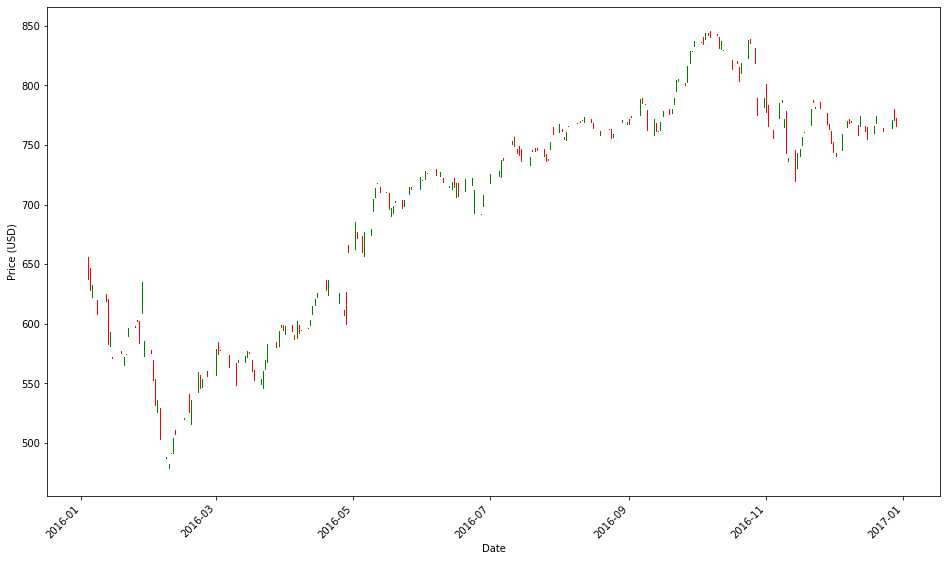

In [10]:
# https://www.statology.org/matplotlib-python-candlestick-chart/

time_period_start = "2016-01-01"
time_period_end = "2017-01-01"

amazon_data_chunk = amazon_data[time_period_start:time_period_end]

plt.figure(figsize=(16,9))

width = 0.4
width2 = 0.05

up = amazon_data_chunk[amazon_data_chunk['Close'] >= amazon_data_chunk['Open']]
down = amazon_data_chunk[amazon_data_chunk['Close'] < amazon_data_chunk['Open']]

# plt.plot(down.index, down["Close"], color='yellow')

# plot up prices
plt.bar(up.index, up["Close"] - up["Open"], width, bottom=up["Open"], color='green')
plt.bar(up.index, up["High"] - up["Close"], width2, bottom=up["Close"], color='green')
plt.bar(up.index, up["Low"] - up["Open"], width2, bottom=up["Open"], color='green')

# plot down prices
plt.bar(down.index, down["Close"] - down["Open"], width, bottom=down["Open"], color='red')
plt.bar(down.index, down['High'] - down["Open"], width2, bottom=down["Open"], color='red')
plt.bar(down.index, down["Low"] - down["Close"], width2, bottom=down["Close"], color='red')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

plt.xlabel('Date')
plt.ylabel('Price (USD)')

#display candlestick chart
plt.show()

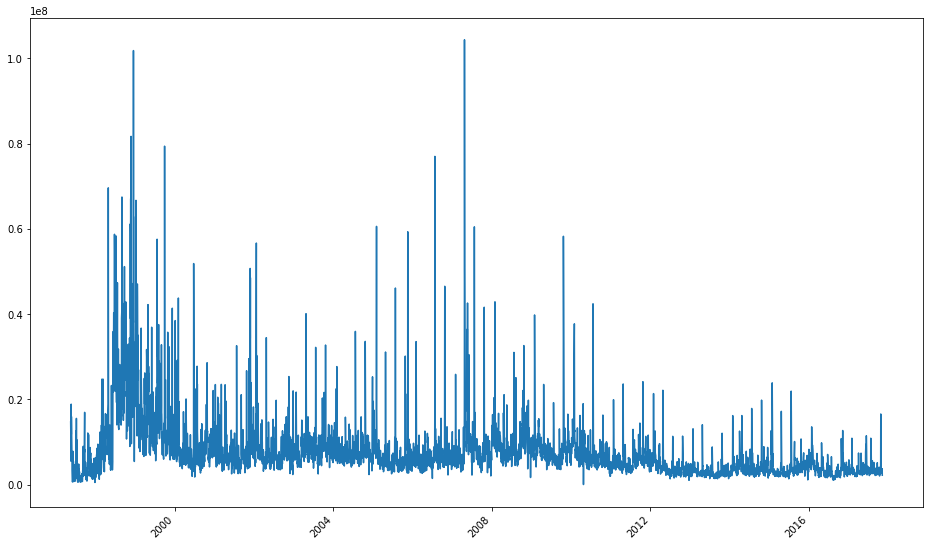

In [11]:
# plot Volume
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Volume"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

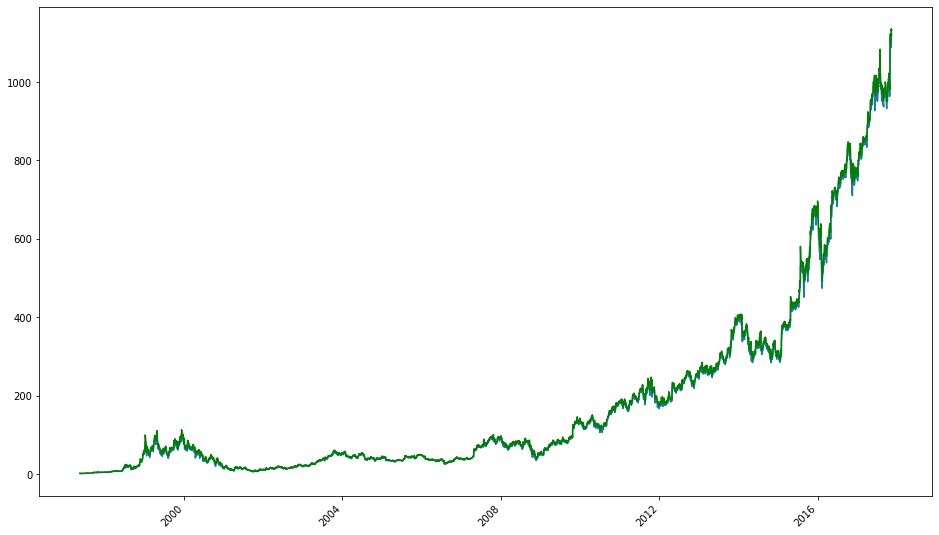

In [12]:
# plot Low, High
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["Low"])
plt.plot(amazon_data.index, amazon_data["High"], 'green')

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

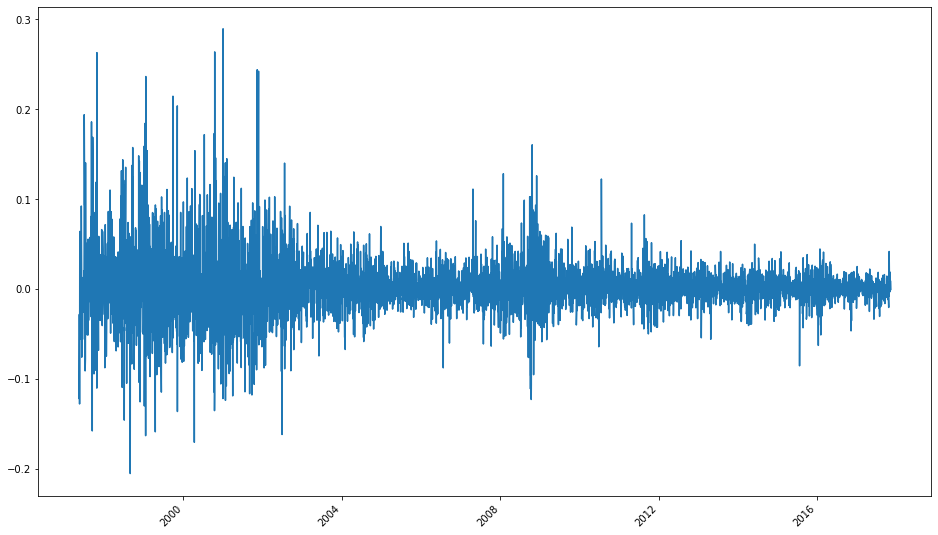

In [13]:
# plot %change
plt.figure(figsize=(16,9))

plt.plot(amazon_data.index, amazon_data["%Change"])

#rotate x-axis tick labels
plt.xticks(rotation=45, ha='right')

#display candlestick chart
plt.show()

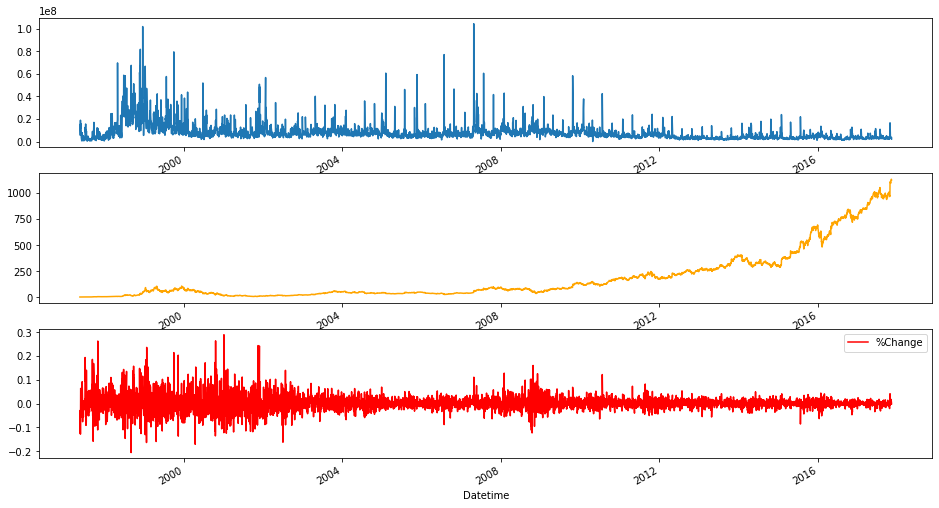

In [14]:
# Plot volume
fig, ax = plt.subplots(3)
amazon_data["Volume"].plot(label='Volume', ax=ax[0])
amazon_data["Close"].plot(color='orange', label='Close', ax=ax[1])
amazon_data["%Change"].plot(color='red', label='%Change', ax=ax[2])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Text(0, 0.5, 'Volume')

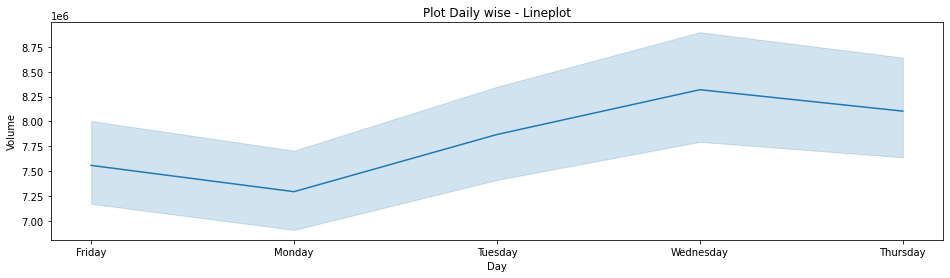

In [15]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Daily wise - Lineplot")
axes[0,0].set_xlabel('Day')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

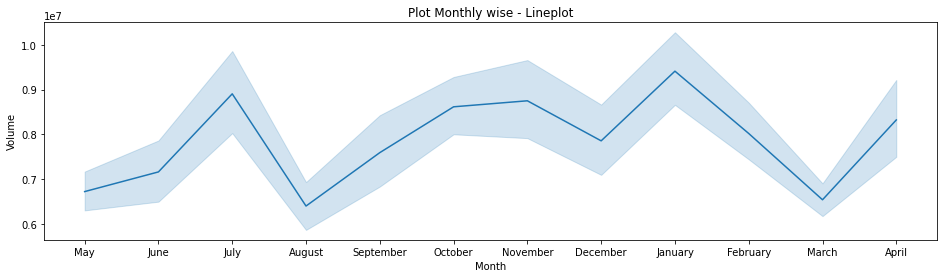

In [16]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Monthly wise - Lineplot")
axes[0,0].set_xlabel('Month')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

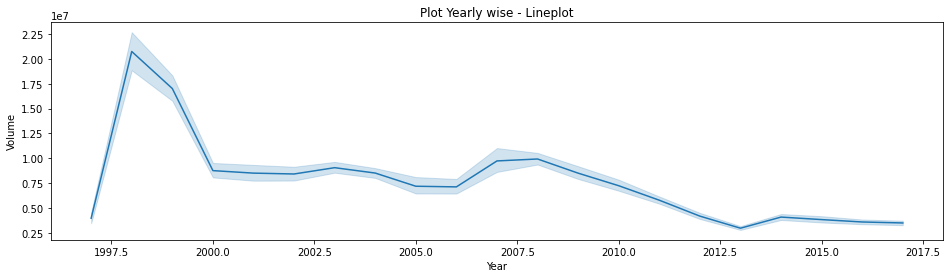

In [17]:
# lineplot from  seaborn package shows the trend-line along with the confidence intervals (i.e. variation of data at each time point)
fig, axes = plt.subplots(1,1,squeeze=False)
fig.set_size_inches(16,4)
sns.lineplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax=axes[0,0])
axes[0,0].set_title("Plot Yearly wise - Lineplot")
axes[0,0].set_xlabel('Year')
axes[0,0].set_ylabel('Volume')

Text(0, 0.5, 'Volume')

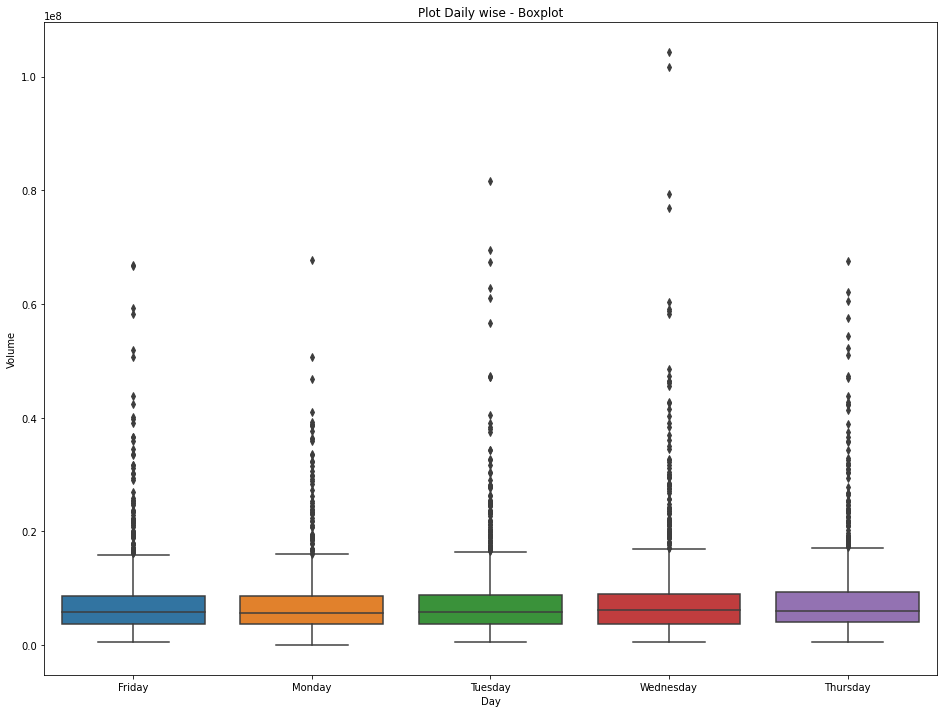

In [18]:
# Boxplot to view daily volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='day', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Daily wise - Boxplot")
ax.set_xlabel('Day')
ax.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

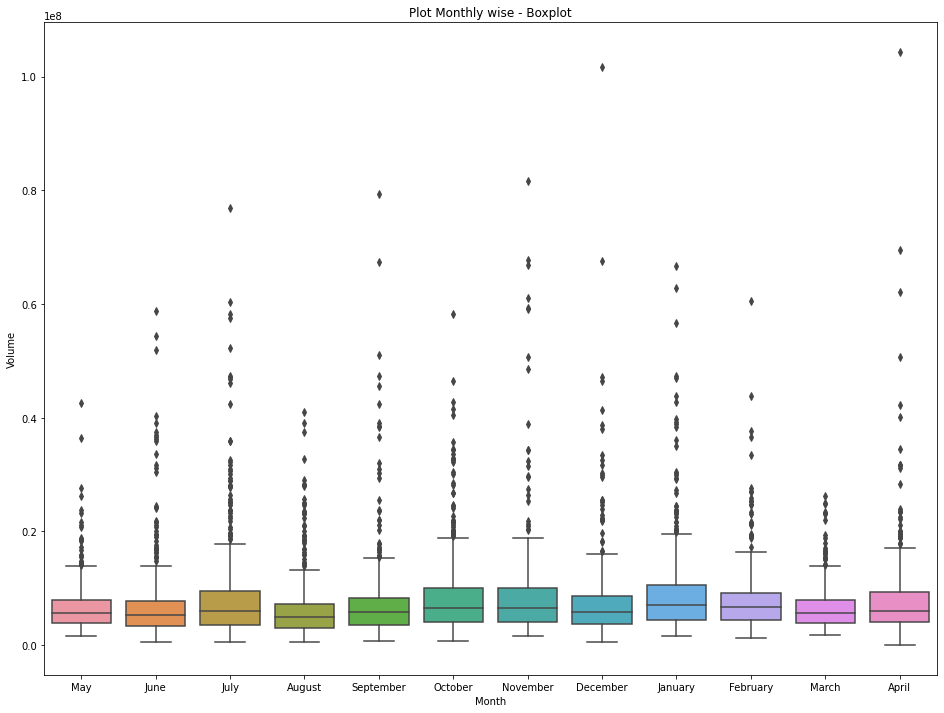

In [19]:
# Boxplot to view monthly volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='month', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Monthly wise - Boxplot")
ax.set_xlabel('Month')
ax.set_ylabel('Volume')

Text(0, 0.5, 'Volume')

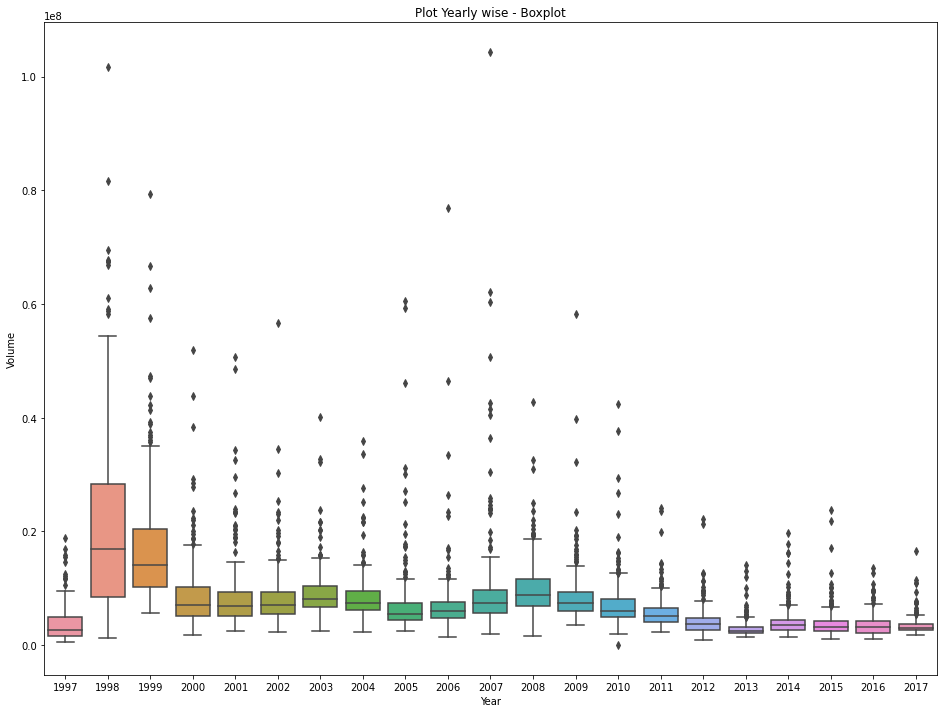

In [20]:
# Boxplot to view yearly volume 
fig, ax = plt.subplots(figsize=(16,12))
sns.boxplot(data=amazon_data, x='year', y=amazon_data['Volume'], ax = ax)
ax.set_title("Plot Yearly wise - Boxplot")
ax.set_xlabel('Year')
ax.set_ylabel('Volume')

# Task 3 - AMZN STR Decomposition
Focus now on the AMZN stock volume time series.

a) Split the data into training and testing series, selecting the testing series to be the last three months of the data.

b) Manually step through the STR decomposition process on the training data, as
described in the course material. Visualise and interpret each of the components of the STR decomposition for volume. (Hint: You may wish to validate the output of your manual process against an automated modelling approach.)

In [21]:
# # Remove all data besides stock volume data
# amazon_data.drop(amazon_data.columns.difference(['Datetime', 'Volume']), axis=1, inplace=True)

div = 5 * 4 * 3 # 5 days a week * 4 weeks a month * 3 months
train_amazon = amazon_data['Volume'][:-div]
test_amazon = amazon_data['Volume'][-div:]
prediction_dates = pd.DataFrame(index=test_amazon.index)

In [22]:
train_amazon

Datetime
1997-05-16    14700000
1997-05-19     6106800
1997-05-20     5467200
1997-05-21    18853200
1997-05-22    11776800
                ...   
2017-08-11     3464884
2017-08-14     3168518
2017-08-15     2544672
2017-08-16     3125793
2017-08-17     3474358
Name: Volume, Length: 5093, dtype: int64

In [23]:
test_amazon

Datetime
2017-08-18     3276718
2017-08-21     3157620
2017-08-22     2745802
2017-08-23     2644883
2017-08-24     5192822
2017-08-25     3318454
2017-08-28     2580401
2017-08-29     2871789
2017-08-30     2898148
2017-08-31     3327043
2017-09-01     2533975
2017-09-05     2996690
2017-09-06     2125703
2017-09-07     2562567
2017-09-08     2589603
2017-09-11     2172012
2017-09-12     2476747
2017-09-13     3362218
2017-09-14     3900801
2017-09-15     3751327
2017-09-18     3400824
2017-09-19     2651065
2017-09-20     2755736
2017-09-21     2276738
2017-09-22     2632770
2017-09-25     5115458
2017-09-26     3562792
2017-09-27     3146172
2017-09-28     2521390
2017-09-29     2513654
2017-10-02     2425704
2017-10-03     2665119
2017-10-04     2518564
2017-10-05     3223573
2017-10-06     3779449
2017-10-09     2936290
2017-10-10     3083184
2017-10-11     2335171
2017-10-12     4083590
2017-10-13     2429486
2017-10-16     2005410
2017-10-17     2318835
2017-10-18     2497400
20

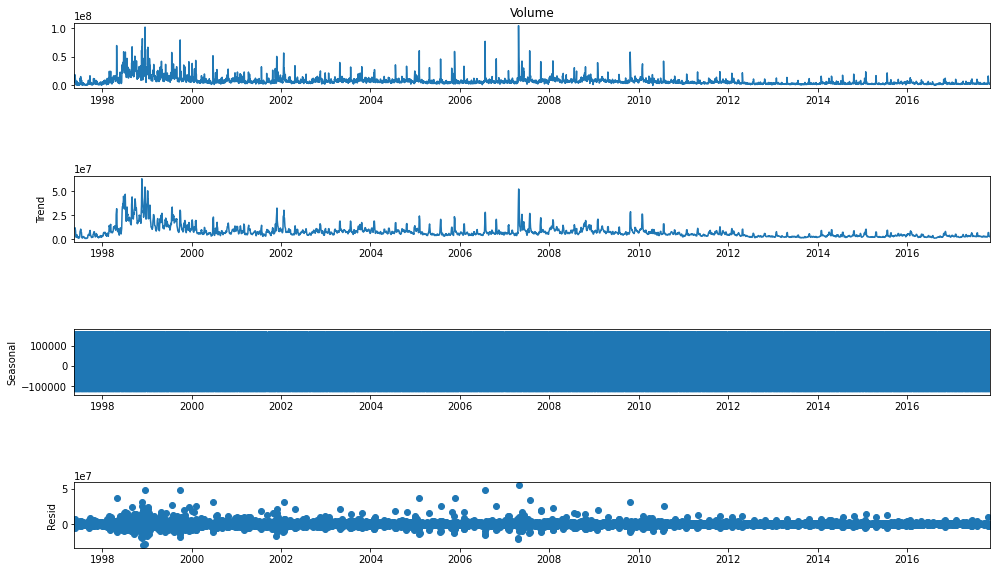

In [24]:
# Jumping ahead - automatic decomposition of temp
from statsmodels.tsa.seasonal import seasonal_decompose

str_res = seasonal_decompose(amazon_data['Volume'],period = (5))
fig = str_res.plot()
fig.set_size_inches((16, 9))

### Isolate Trend
Since we have a weekly cycle we can roll to 1 and 2 weeks and look at the plot

In [25]:
amazon_data['MA5 Trend'] = amazon_data['Volume'].rolling(5).mean() # 1 week
amazon_data['MA10 Trend'] = amazon_data['Volume'].rolling(10).mean() # 2 week
amazon_data['MA20 Trend'] = amazon_data['Volume'].rolling(20).mean() # 1 month
amazon_data['MA60 Trend'] = amazon_data['Volume'].rolling(60).mean() # 3 months
amazon_data['MA120 Trend'] = amazon_data['Volume'].rolling(120).mean() # 6 months
amazon_data['MA180 Trend'] = amazon_data['Volume'].rolling(180).mean() # 9 months
amazon_data['MA240 Trend'] = amazon_data['Volume'].rolling(240).mean() # 12 months
amazon_data['MA480 Trend'] = amazon_data['Volume'].rolling(480).mean() # 24 months
amazon_data['MA720 Trend'] = amazon_data['Volume'].rolling(720).mean() # 36 months

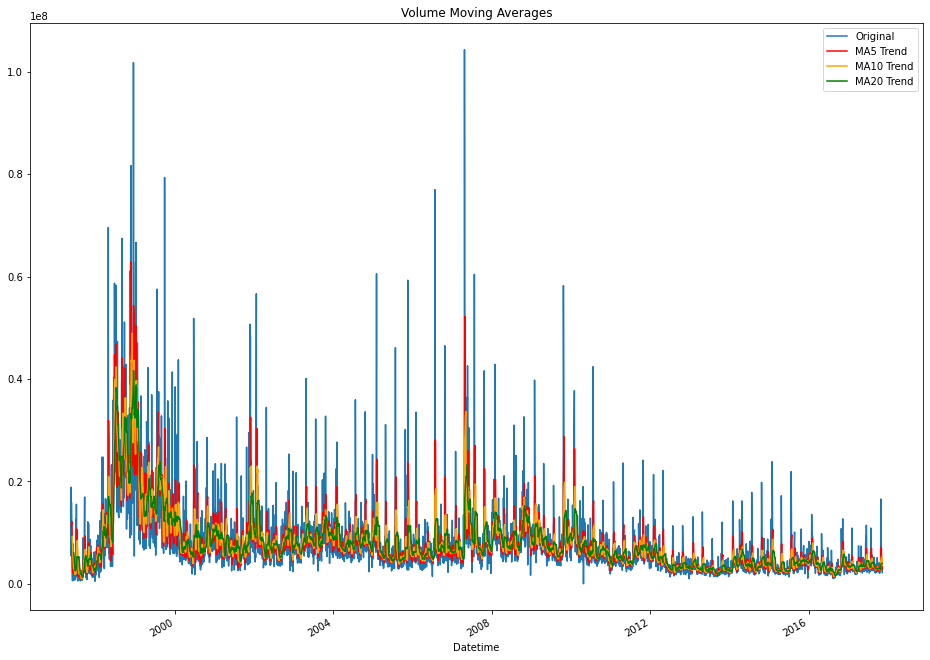

In [26]:
fig, ax = plt.subplots()
amazon_data['Volume'].plot(label='Original', ax=ax)
amazon_data['MA5 Trend'].plot(color='red', label='MA5 Trend', ax=ax)
amazon_data['MA10 Trend'].plot(color='orange', label='MA10 Trend', ax=ax)
amazon_data['MA20 Trend'].plot(color='green', label='MA20 Trend', ax=ax)
# amazon_data['MA60 Trend'].plot(color='orange', label='MA60 Trend', ax=ax)
# amazon_data['MA120 Trend'].plot(color='blue', label='MA60 Trend', ax=ax)
# amazon_data['MA180 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax) # chosen in tut
# amazon_data['MA240 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA480 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
# amazon_data['MA720 Trend'].plot(color='yellow', label='MA60 Trend', ax=ax)
plt.title('Volume Moving Averages')
fig.set_size_inches((16, 12))
plt.legend()
plt.show()

<AxesSubplot:xlabel='Datetime'>

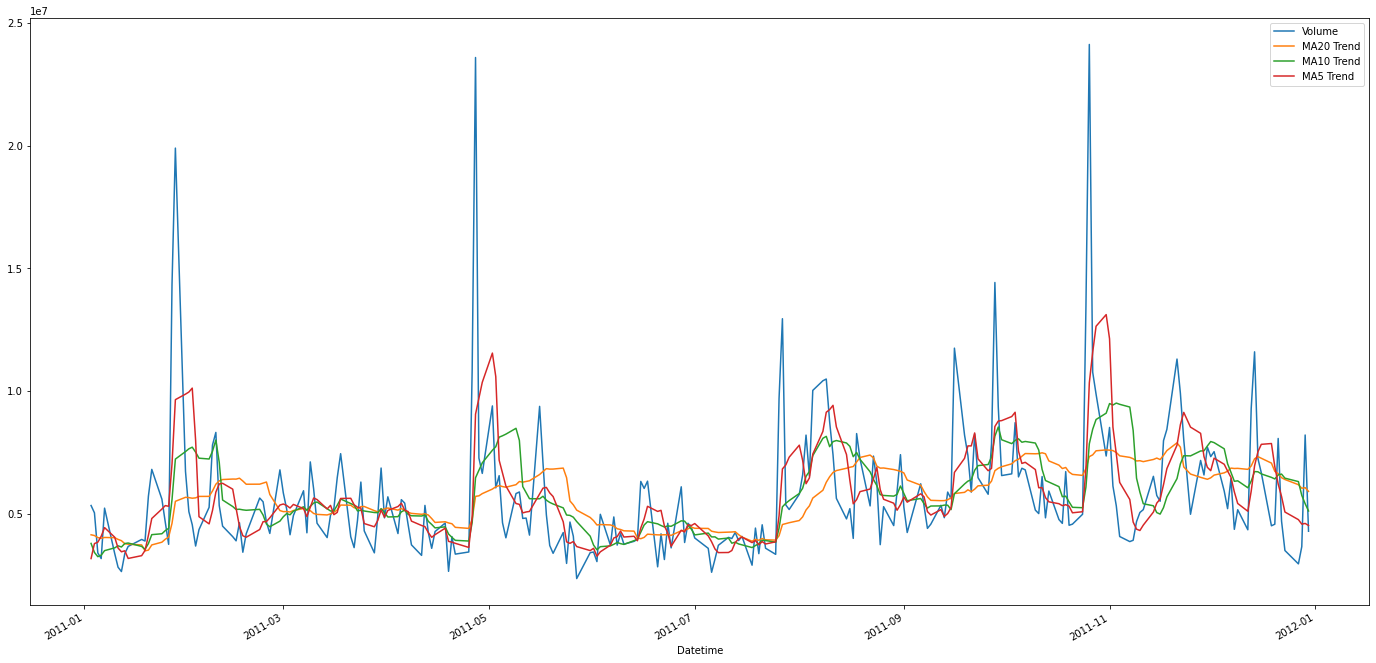

In [27]:
amazon_data['2011':'2011'][['Volume', 'MA20 Trend', 'MA10 Trend', 'MA5 Trend']].plot(figsize=(24,12))

<AxesSubplot:xlabel='Datetime'>

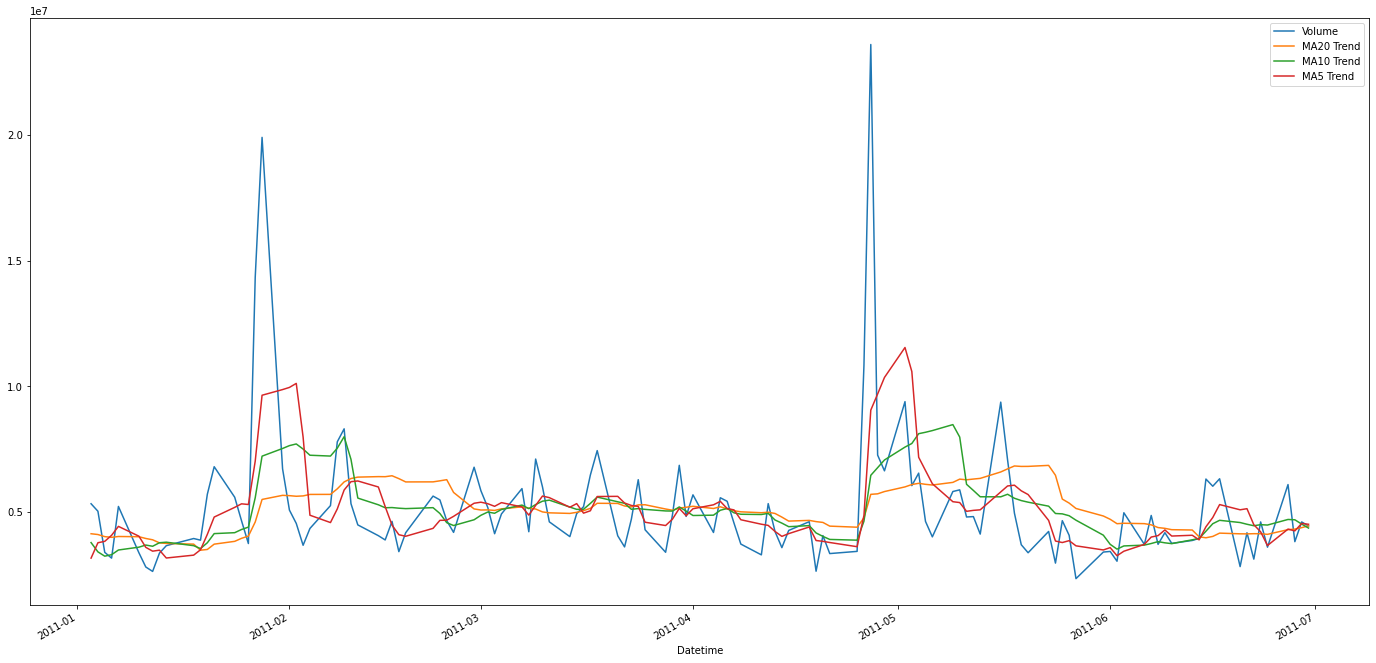

In [28]:
amazon_data['2011-01':'2011-06'][['Volume', 'MA20 Trend', 'MA10 Trend', 'MA5 Trend']].plot(figsize=(24,12))

Go with MA-5 shows a pattern but its not seasonality??

In [29]:
rolling_period = 'MA5 Trend'

### Detrend the Series

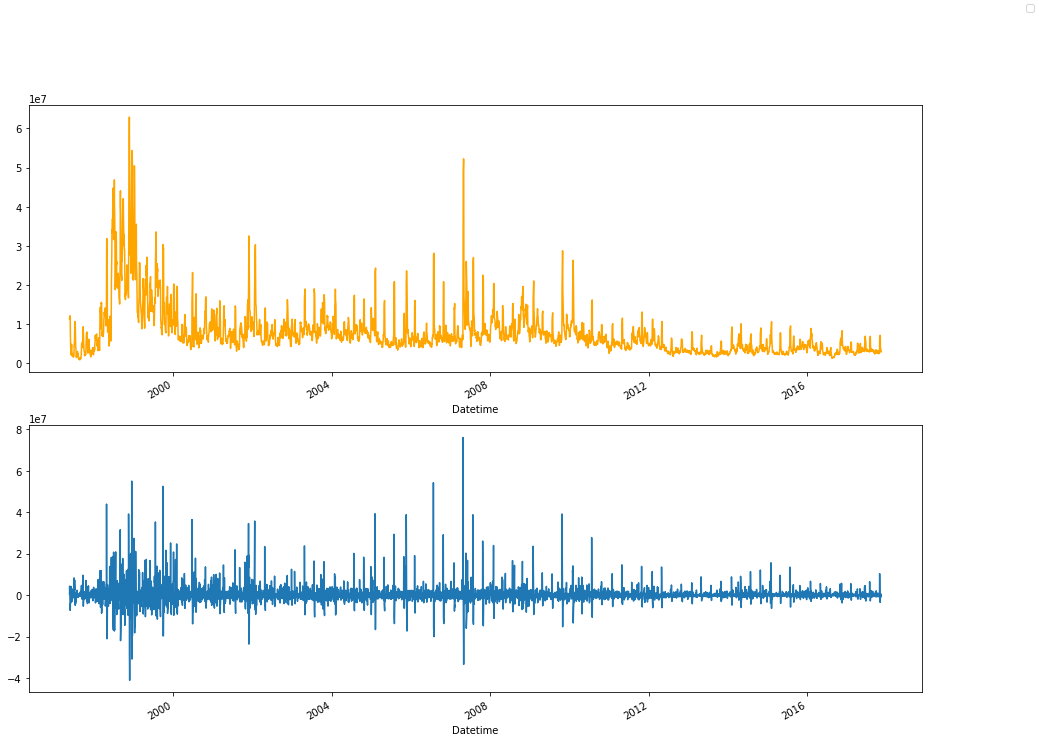

In [30]:
# De-trended data
amazon_data['De-trended'] = amazon_data['Volume'] - amazon_data[rolling_period]

fig, ax = plt.subplots(2)
amazon_data[rolling_period].plot(color='orange', label=rolling_period, ax=ax[0])
amazon_data['De-trended'].plot(label='De-trended', ax=ax[1])
fig.set_size_inches((16, 12))
fig.legend([])
plt.show()

### Estimate seasonal component

<AxesSubplot:xlabel='Datetime'>

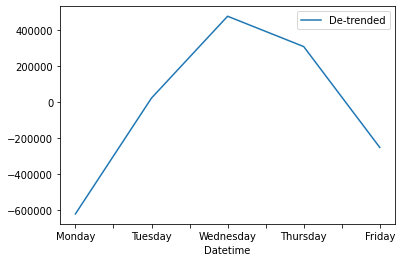

In [31]:
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
# https://pandas.pydata.org/docs/reference/api/pandas.DatetimeIndex.dayofweek.html
# https://sparkbyexamples.com/pandas/pandas-remap-values-in-column-with-a-dictionary-dict/
# https://stackoverflow.com/questions/40427943/how-do-i-change-a-single-index-value-in-pandas-dataframe
raw_daily_means = amazon_data.groupby(amazon_data.index.dayofweek)['De-trended'].mean()
raw_daily_means = raw_daily_means.to_frame()
raw_daily_means = raw_daily_means.rename(index={0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4:'Friday'})
raw_daily_means.plot()

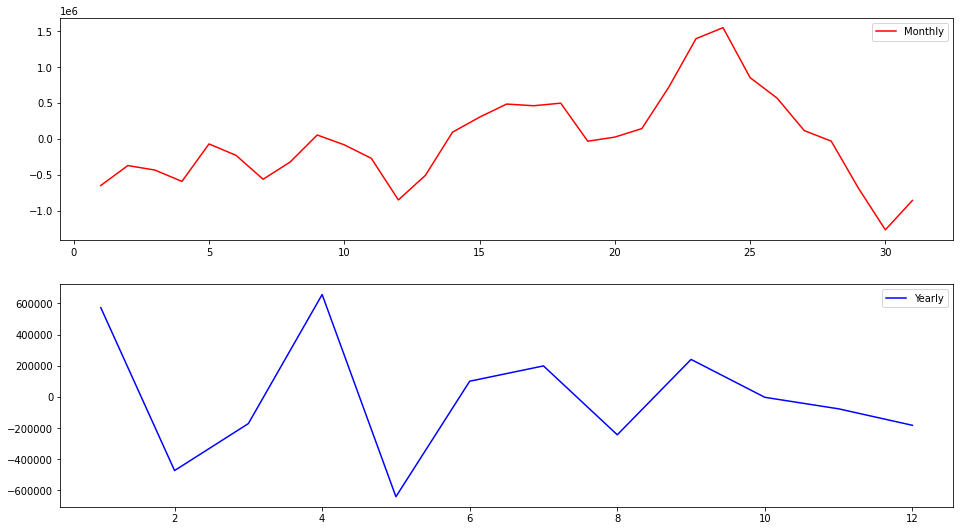

In [32]:
# Test seasonal component for monthly data
raw_monthly_means = amazon_data.groupby(amazon_data.index.day)['De-trended'].mean()
raw_yearly_means = amazon_data.groupby(amazon_data.index.month)['De-trended'].mean()

fig, (ax1, ax2) = plt.subplots(2)
# raw_monthly_means.plot(ax=ax[0], color='orange')
# raw_yearly_means.plot(ax=ax[1])
fig.set_size_inches((16, 9))

ax1.plot(raw_monthly_means, color='r', label='Monthly')
ax1.legend(loc='upper right')
ax2.plot(raw_yearly_means, color='b', label='Yearly')
ax2.legend(loc='upper right')

In [33]:
print(type(fig))

<class 'matplotlib.figure.Figure'>


In [34]:
season_length = len(raw_daily_means.index)

Seasonal Components need to sum to zero, we will introduce an adjustment

In [35]:
# Shift values so that seasonal components sum to zero
adjustment = raw_daily_means.sum()/season_length
daily_means = raw_daily_means - adjustment

# daily_means.plot()
# print(type(daily_means))

# Convert df to series
daily_means = daily_means.squeeze()

Now we fill the series for the entire duration of the timeseries
1. Get the lenth of the seasonal data input equal to the length of df_temp
2. Start the seasonal data at the correct time step

In [36]:
# tile the values into the dataframe so that the entire series is filled
seasonal = np.tile(daily_means, int(np.floor(len(amazon_data)/season_length)))

print(f"seasonal length = {len(seasonal)}  amazon_data = {len(amazon_data)}")

seasonal length = 5150  amazon_data = 5153


In [37]:
# # tile the values into the dataframe so that the entire series is filled
# seasonal = np.tile(daily_means,int(np.floor(len(amazon_data)/season_length)))
# used typeout to check lengths:
# len(seasonal), len(df_temp)
# These are not the same so go back to check start time of series - 11PM!! - which explains the extra observation. 
# Prepending one observation
seasonal = np.insert(seasonal, 0, daily_means[season_length - 1])

# TEMP add 2 values to end of dataframe
seasonal = np.insert(seasonal, len(seasonal - 1), daily_means[0])
seasonal = np.insert(seasonal, len(seasonal - 1), daily_means[1])

amazon_data['temp-seasonal'] = seasonal

<AxesSubplot:xlabel='Datetime'>

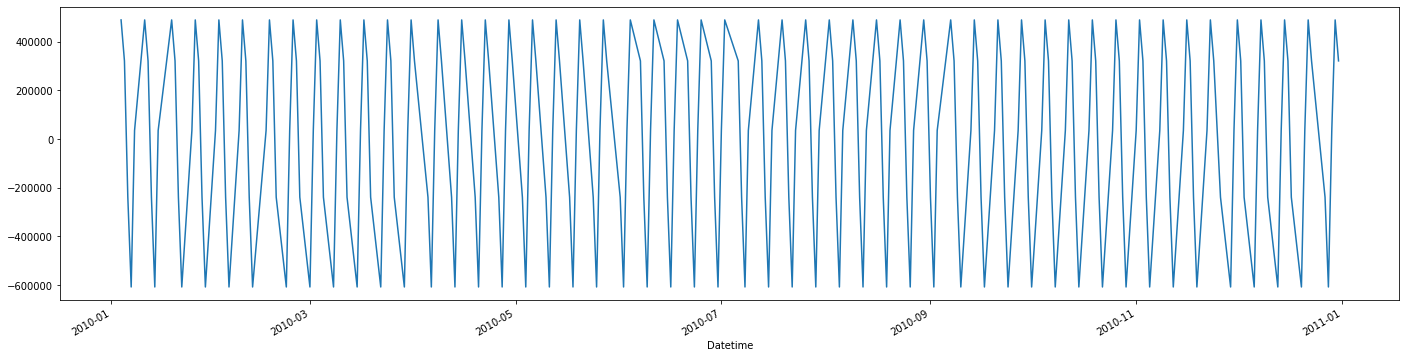

In [38]:
amazon_data['2010':'2010']['temp-seasonal'].plot(figsize=(24,6))

### Calculate the residual component
The last step is to calulate the residual, by subtracting the seasonal component from the detrended data.

<AxesSubplot:xlabel='Datetime'>

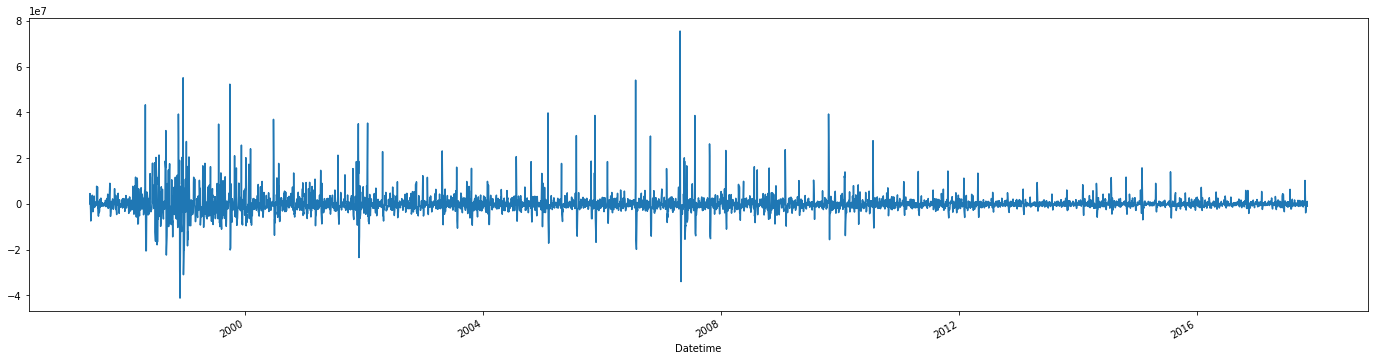

In [39]:
amazon_data['temp-residual'] = amazon_data['De-trended'] - amazon_data['temp-seasonal']
amazon_data['temp-residual'].plot(figsize=(24,6))

Putting all 4 plots into the same figure

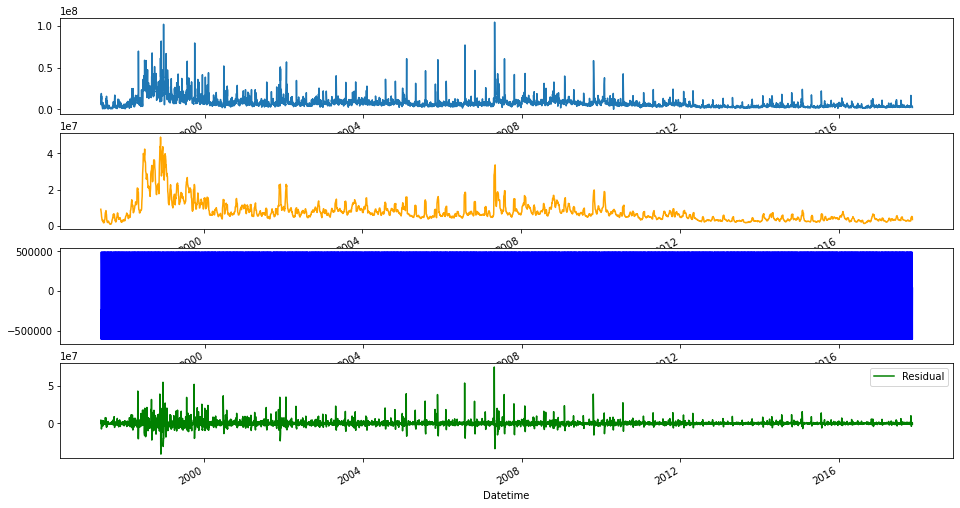

In [40]:
fig, ax_str = plt.subplots(4)
amazon_data['Volume'].plot(label='Original', ax=ax_str[0])
amazon_data['MA10 Trend'].plot(color='orange', label='MA10 Trend', ax=ax_str[1])
amazon_data['temp-seasonal'].plot(color='blue', label='Seasonal', ax=ax_str[2])
amazon_data['temp-residual'].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

Looking closer at one month

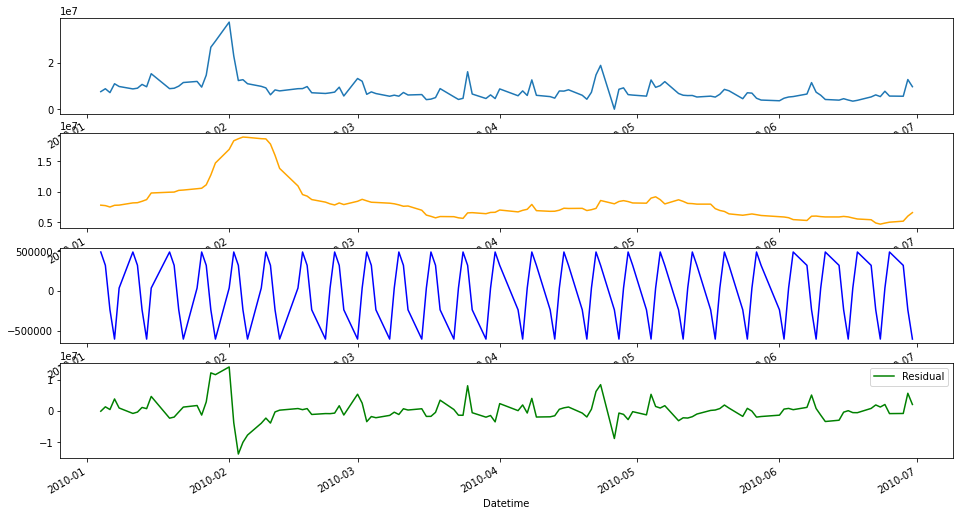

In [41]:
fig, ax_str = plt.subplots(4)
amazon_data['Volume']["2010-01":"2010-06"].plot(label='Original', ax=ax_str[0])
amazon_data['MA10 Trend']["2010-01":"2010-06"].plot(color='orange', label='MA10 Trend', ax=ax_str[1])
amazon_data['temp-seasonal']["2010-01":"2010-06"].plot(color='blue', label='Seasonal', ax=ax_str[2])
amazon_data['temp-residual']["2010-01":"2010-06"].plot(color='green', label= 'Residual', ax=ax_str[3])
fig.set_size_inches((16, 9))
plt.legend()
plt.show()

# Task 4 - Timeseries Models
a) Fit an ARIMA model for the trend-cycle component of your STR decomposition of the training data and interpret the estimated model parameters.

b) Using the STR components that you estimated in tasks 3 and 4, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts and visualise the predictions.

### Check for stationarity
To fig an autoregressive model or an ARIMA model that contains an AR component, the data must be stationary. The criteria for stationarity is that the data is:
- roughly horizontal
- constant variance
- no patterns predictable in the long-term

<AxesSubplot:xlabel='Datetime'>

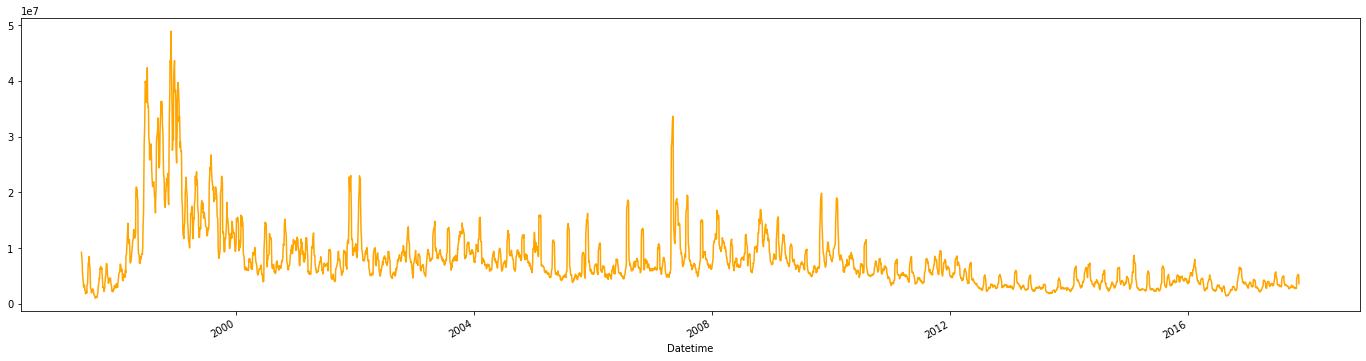

In [42]:
amazon_data['MA10 Trend'].plot(color='orange', figsize=(24,6))

Perform first differencing 

<AxesSubplot:xlabel='Datetime'>

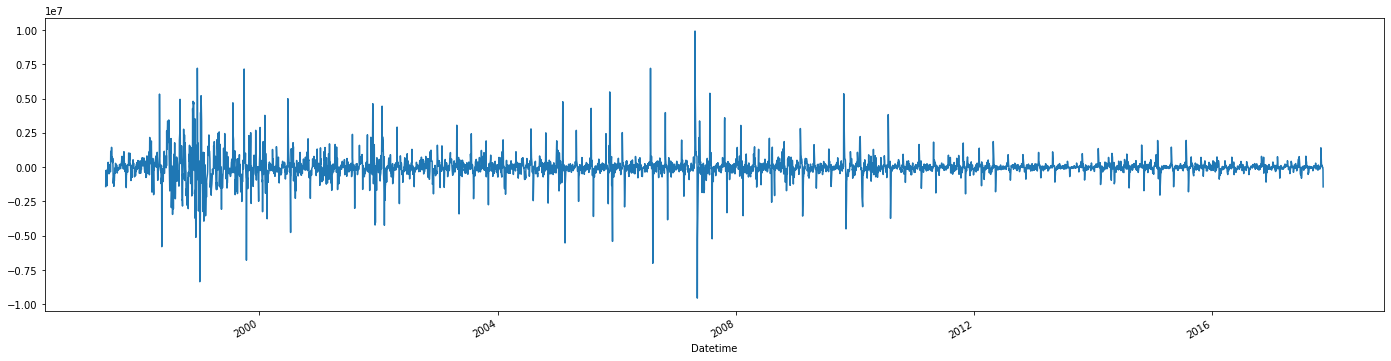

In [43]:
trend_d1 = amazon_data['MA10 Trend'].diff()
trend_d1.plot(figsize=(24,6))

<AxesSubplot:xlabel='Datetime'>

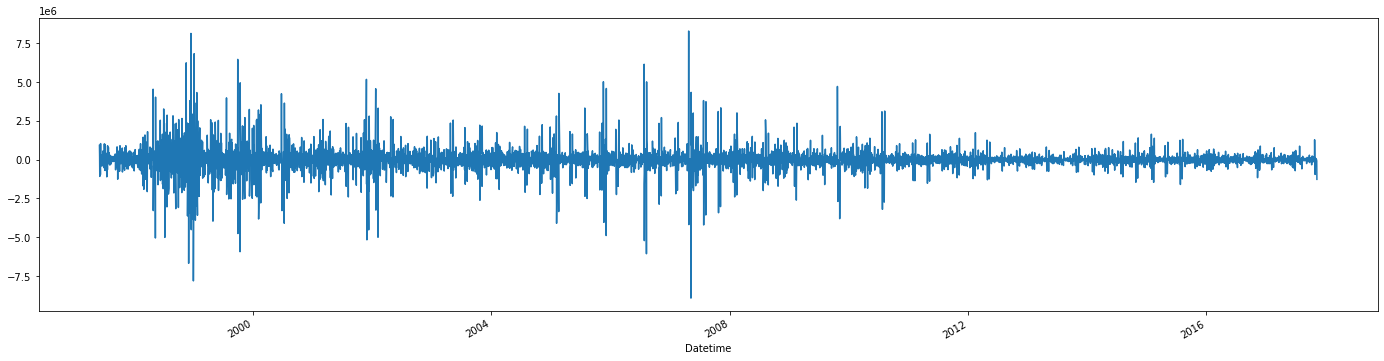

In [44]:
trend_d2 = trend_d1.diff()
trend_d2.plot(figsize=(24,6))

The differencing plot does not seem to change when going from first to second differencing. Therefore, we will select the first differencing. 

d = 1

## Fit a lower order model

In [45]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_predict
import statsmodels.api as sm

## Is there Evidence of autocorrelation?

In [46]:
# trim th nan's from the differenced trend
trend_d1 = trend_d1[10:].copy()

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


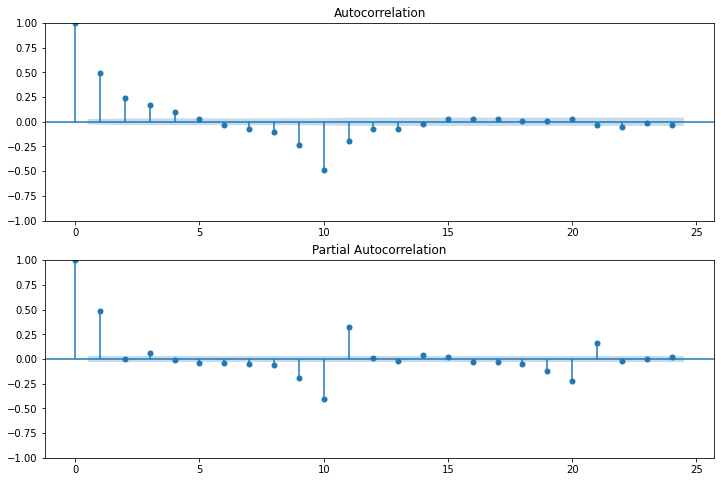

In [47]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(trend_d1, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(trend_d1, lags=24, ax=ax2)

### Fit the ARIMA Model

In [48]:
arima_data = amazon_data[rolling_period][4:-div]
arima_data.tail()

Datetime
2017-08-11    3639166.6
2017-08-14    3738813.8
2017-08-15    3669845.2
2017-08-16    3581375.2
2017-08-17    3155645.0
Name: MA5 Trend, dtype: float64

In [49]:
arima_1_1_0 = ARIMA(arima_data, order=(1, 1, 0)).fit()
print(arima_1_1_0.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              MA5 Trend   No. Observations:                 5089
Model:                 ARIMA(1, 1, 0)   Log Likelihood              -79207.854
Date:                Tue, 01 Nov 2022   AIC                         158419.708
Time:                        11:19:16   BIC                         158432.778
Sample:                             0   HQIC                        158424.285
                               - 5089                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4751      0.006     75.795      0.000       0.463       0.487
sigma2      1.942e+12   1.17e-15   1.67e+27      0.000    1.94e+12    1.94e+12
Ljung-Box (L1) (Q):                   5.45   Jarque-

In [50]:
arima_2_1_0 = ARIMA(arima_data, order=(2, 1, 0)).fit()
print(arima_2_1_0.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              MA5 Trend   No. Observations:                 5089
Model:                 ARIMA(2, 1, 0)   Log Likelihood              -79198.980
Date:                Tue, 01 Nov 2022   AIC                         158403.961
Time:                        11:19:17   BIC                         158423.565
Sample:                             0   HQIC                        158410.825
                               - 5089                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5035      0.008     66.959      0.000       0.489       0.518
ar.L2         -0.0587      0.007     -7.854      0.000      -0.073      -0.044
sigma2      1.935e+12   3.04e-15   6.36e+26      0.0

### Comparing Goodness of fit of ARIMA models

Looking at the outputs: 
- AIC for ARIMA(1,1,0) = 158443, for ARIMA(2,1,0) = 158427
- BIC for ARIMA(1,1,0) = 158456, for ARIMA(2,1,0) = 158447
The drop in AIC and BIC is very small so therefore we will go with ARIMA(1,1,0)

Next we will see if ARIMA(1,1,1) gives us any improvements

In [51]:
arima_1_1_1 = ARIMA(arima_data, order=(1, 1, 1)).fit()
print(arima_1_1_1.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:              MA5 Trend   No. Observations:                 5089
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -79200.481
Date:                Tue, 01 Nov 2022   AIC                         158406.963
Time:                        11:19:18   BIC                         158426.567
Sample:                             0   HQIC                        158413.828
                               - 5089                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3954      0.014     29.058      0.000       0.369       0.422
ma.L1          0.1043      0.016      6.686      0.000       0.074       0.135
sigma2      1.936e+12   3.98e-15   4.86e+26      0.0

Looking at the outputs: 
- AIC for ARIMA(1,1,0) = 158443, for ARIMA(1,1,1) = 158430
- BIC for ARIMA(1,1,0) = 158456, for ARIMA(1,1,1) = 158450
Again, the drop in AIC and BIC is very small so therefore we will go with ARIMA(1,1,0)

### Inspect the residuals

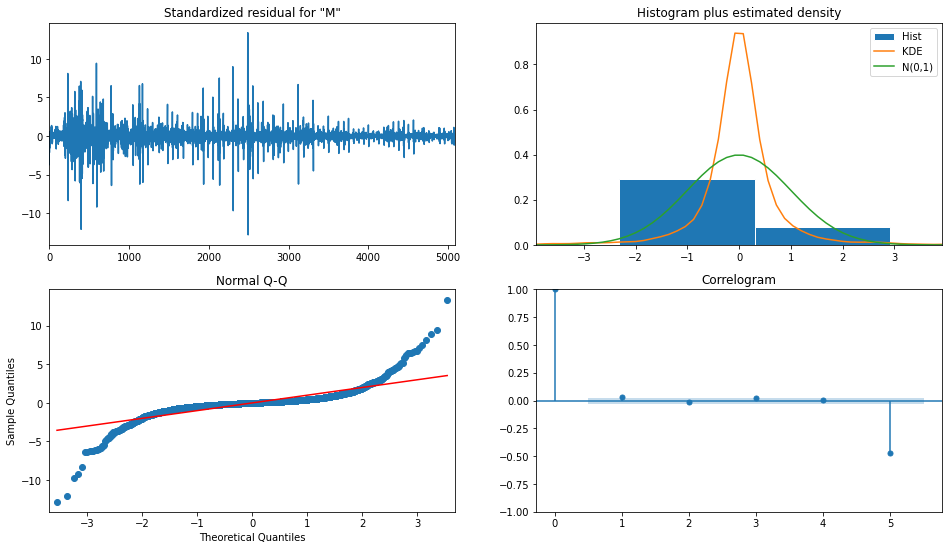

In [52]:
fig = plt.figure(figsize=(16, 9))
fig = arima_1_1_0.plot_diagnostics(fig=fig, lags=5)

In [53]:
# amazon_data.head(20)
test_amazon.index
# print(type(test_amazon.index))
print(type(arima_data))

<class 'pandas.core.series.Series'>


In [54]:
arima_pred = pd.DataFrame(index=test_amazon.index)

# # print(test_amazon.index)
# # arima_pred['Trend'] = arima_1_1_0.predict(dates=prediction_dates)
# arima_pred['Trend'] = arima_1_1_0.predict(start="2017-08-17", end="2017-08-18")
# start = len(train_amazon)
# end = len(train_amazon) + len(test_amazon) - 1
# # arima_pred['Trend'] = arima_1_1_0.predict(start=start, end=end)
# arima_pred.head(100)

In [109]:
# arima_pred['Trend'] = arima.predict(start="2017-08-18", end="2017-08-18")

KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [55]:
#  https://stackoverflow.com/questions/58580633/the-start-argument-could-not-be-matched-to-a-location-related-to-the-index-of
# arima_1_1_0 last date is 2017-08-17 I want to predict up to 2017-11-10
# arima_pred['Trend'] = arima_1_1_0.predict(start="2017-08-17", end="2017-11-10")
arima_pred['Trend'] = arima_1_1_0.predict(start=train_amazon.shape[0], end=(train_amazon.shape[0] + test_amazon.shape[0] - 1))

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [56]:
arima_pred['Trend']

Datetime
2017-08-18   NaN
2017-08-21   NaN
2017-08-22   NaN
2017-08-23   NaN
2017-08-24   NaN
2017-08-25   NaN
2017-08-28   NaN
2017-08-29   NaN
2017-08-30   NaN
2017-08-31   NaN
2017-09-01   NaN
2017-09-05   NaN
2017-09-06   NaN
2017-09-07   NaN
2017-09-08   NaN
2017-09-11   NaN
2017-09-12   NaN
2017-09-13   NaN
2017-09-14   NaN
2017-09-15   NaN
2017-09-18   NaN
2017-09-19   NaN
2017-09-20   NaN
2017-09-21   NaN
2017-09-22   NaN
2017-09-25   NaN
2017-09-26   NaN
2017-09-27   NaN
2017-09-28   NaN
2017-09-29   NaN
2017-10-02   NaN
2017-10-03   NaN
2017-10-04   NaN
2017-10-05   NaN
2017-10-06   NaN
2017-10-09   NaN
2017-10-10   NaN
2017-10-11   NaN
2017-10-12   NaN
2017-10-13   NaN
2017-10-16   NaN
2017-10-17   NaN
2017-10-18   NaN
2017-10-19   NaN
2017-10-20   NaN
2017-10-23   NaN
2017-10-24   NaN
2017-10-25   NaN
2017-10-26   NaN
2017-10-27   NaN
2017-10-30   NaN
2017-10-31   NaN
2017-11-01   NaN
2017-11-02   NaN
2017-11-03   NaN
2017-11-06   NaN
2017-11-07   NaN
2017-11-08   NaN
2017-

In [57]:
# Using forcast
arima_fcst = arima_1_1_0.get_forecast(steps=60)
arima_predictions = pd.DataFrame(arima_fcst.predicted_mean)
arima_predictions.rename(columns={"predicted_mean": "trend"}, inplace=True)
# arima_predictions.head()

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [58]:
# print(f"length predictions = {len(prediction_dates)}  length pred = {len(arima_predictions)}")
# print(type(arima_predictions))
# set the index to be the dates
# arima_predictions['Datetime'] = prediction_dates

arima_predictions.index = prediction_dates.index
# amazon_data = amazon_data.set_index('Datetime')
# arima_predictions

In [59]:
# train_amazon.head()

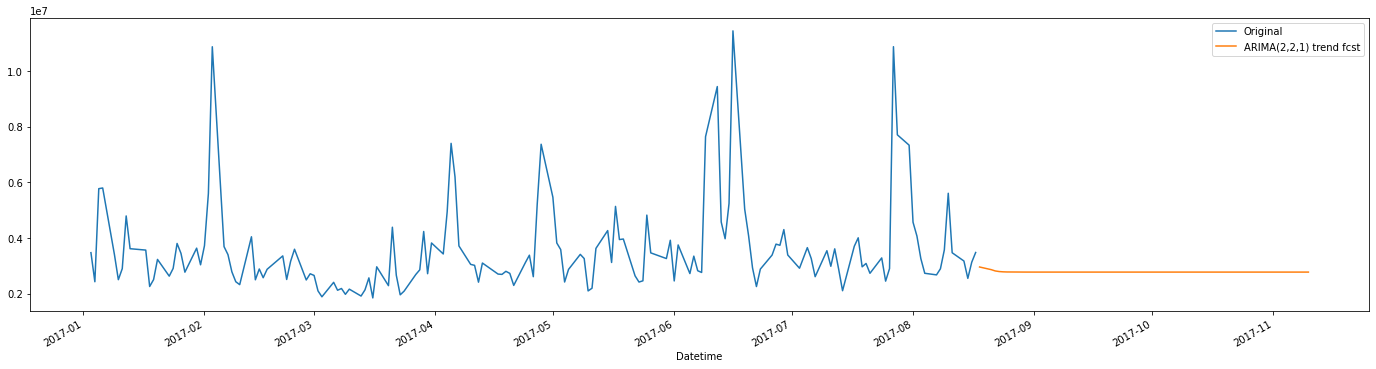

In [60]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,6))
train_amazon['2017':'2017'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['2017':'2017']['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
plt.legend()

### Add Seasonality back into forecasts

In [61]:
# amazon_data['2010':'2010']['temp-seasonal'].plot(figsize=(24,6))
# print(type(prediction_dates.index.to_list()))
# amazon_data.loc(prediction_dates.index.to_list())

# amazon_data[-div:]['temp-seasonal']

arima_predictions['seasonal'] = amazon_data[-div:]['temp-seasonal']
arima_predictions.head(60)

,trend,seasonal
Datetime,,
2017-08-18,2.953381e+06,489541.553110
2017-08-21,2.857286e+06,321208.346404
2017-08-22,2.811631e+06,-238684.092115
2017-08-23,2.789940e+06,-607600.829006
2017-08-24,2.779635e+06,35535.021607
2017-08-25,2.774739e+06,489541.553110
2017-08-28,2.772413e+06,321208.346404
2017-08-29,2.771308e+06,-238684.092115
2017-08-30,2.770783e+06,-607600.829006


In [62]:
arima_predictions['trend+seasonal'] = arima_predictions['trend'] + arima_predictions['seasonal']
arima_predictions.tail()

,trend,seasonal,trend+seasonal
Datetime,,,
2017-11-06,2.770308e+06,489541.553110,3.259849e+06
2017-11-07,2.770308e+06,321208.346404,3.091516e+06
2017-11-08,2.770308e+06,-238684.092115,2.531624e+06
2017-11-09,2.770308e+06,-607600.829006,2.162707e+06
2017-11-10,2.770308e+06,35535.021607,2.805843e+06


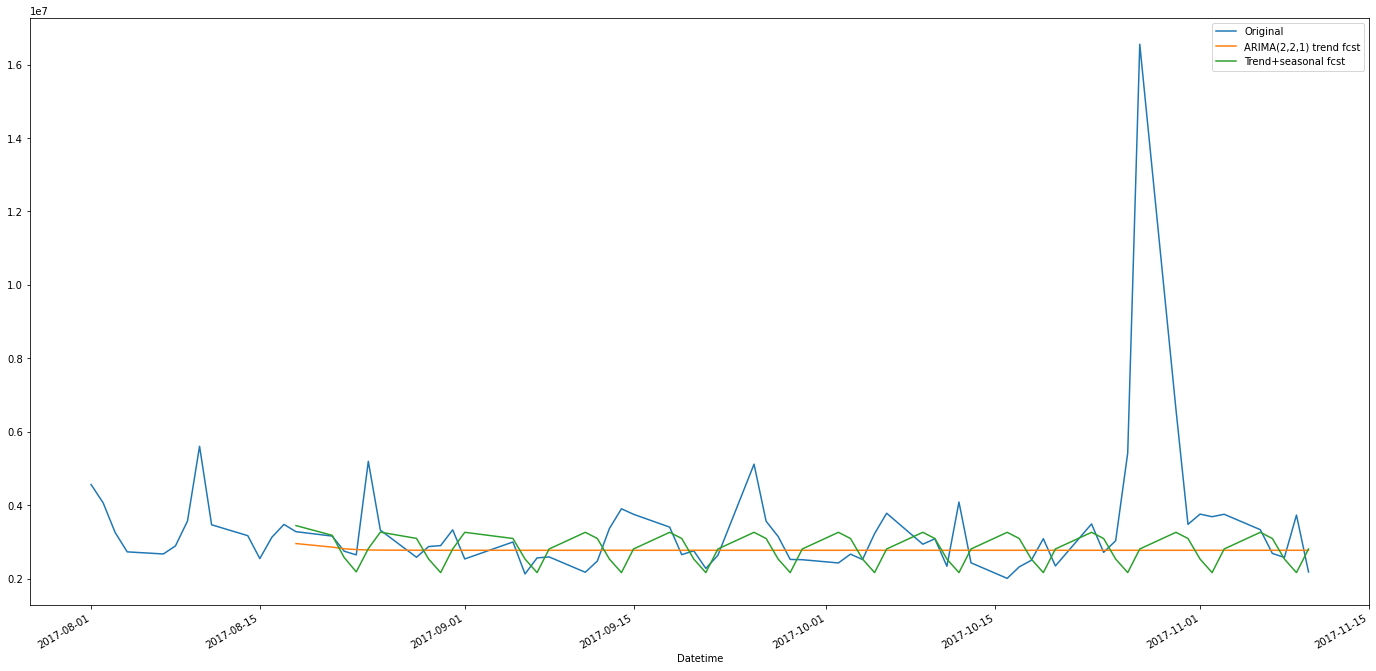

In [63]:
fig, ax_arima_fcst = plt.subplots(figsize=(24,12))
amazon_data["2017-08":"2017-12"]['Volume'].plot(label='Original', ax=ax_arima_fcst)
arima_predictions['trend'].plot(label="ARIMA(2,2,1) trend fcst", ax=ax_arima_fcst)
arima_predictions['trend+seasonal'].plot(label="Trend+seasonal fcst", ax=ax_arima_fcst)
plt.legend()

Plotting a confidence interval for the trend.

/tmp/ipykernel_403255/3122194053.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  from pandas import datetime


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

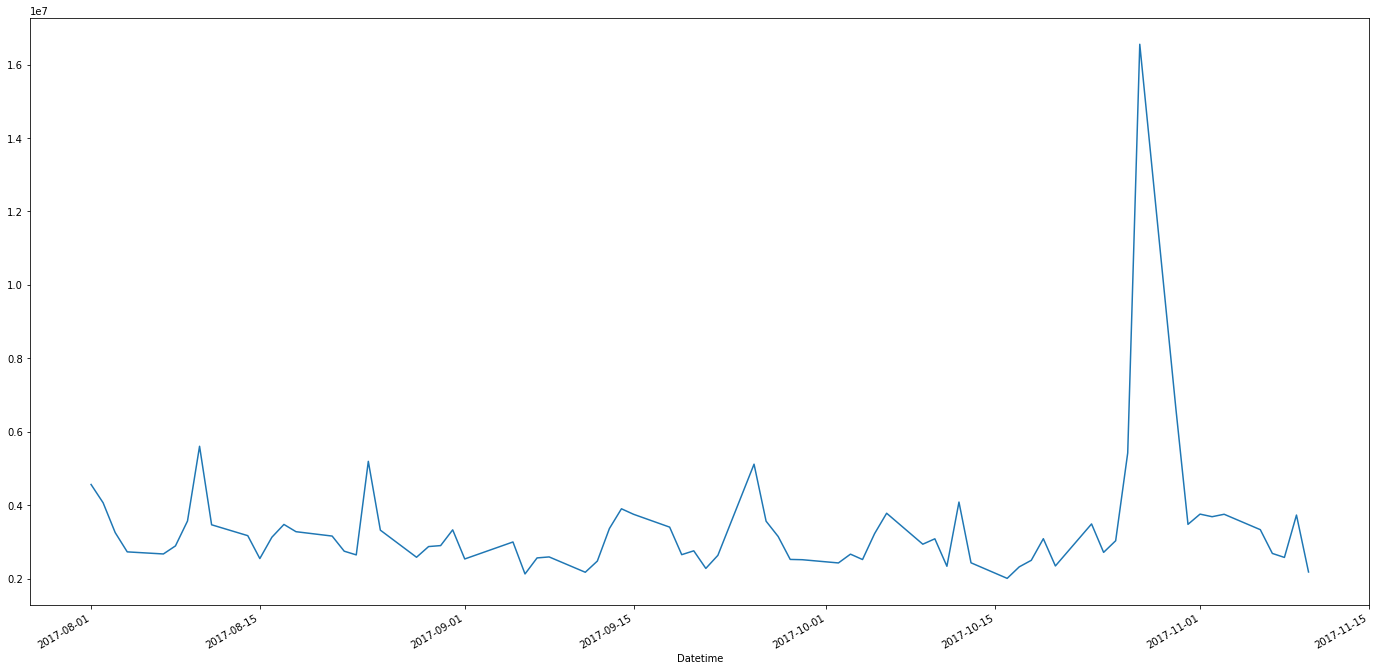

In [110]:
# from pandas import datetime
# start = datetime(2017, 8, 18)
# end = datetime(2017, 11, 10)

# fig, ax_arima_fcst = plt.subplots(figsize=(24,12))
# amazon_data["2017-08":"2017-12"]['Volume'].plot(label='Original', ax=ax_arima_fcst)
# fig = plot_predict(arima_1_1_0, start=start, end=end, label='ARIMA(2,2,1) Forecast', ax=ax_arima_fcst)

# Task 5 - Pure Forcasters
now consider your choice of ML techniques

a) Select an appropriate pure forecasting method to predict the trend component of the volume training data.

b) Using the seasonal component that you estimated in task 3 and the pure forecaster from 5.a, produce forecasts of AMZN stock volumes for the test data series. Include the uncertainty in the forecasts, and visualise the predictions.

In [65]:
# !pip3 uninstall tensorflow-cpu -y
from tensorflow import keras
from sklearn.preprocessing import MinMaxScaler

2022-11-01 11:19:20.335872: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-01 11:19:20.624330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-01 11:19:20.624405: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-01 11:19:20.671083: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-01 11:19:21.844848: W tensorflow/stream_executor/platform/de

Scale the data and split into train test.

In [66]:
amazon_data

,Open,High,Low,Close,Volume,OpenInt,Change,%Change,year,month,...,MA20 Trend,MA60 Trend,MA120 Trend,MA180 Trend,MA240 Trend,MA480 Trend,MA720 Trend,De-trended,temp-seasonal,temp-residual
Datetime,,,,,,,,,,,,,,,,,,,,,
1997-05-16,1.97,1.98,1.71,1.73,14700000,0,-0.24,-0.121827,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-238684.092115,NaN
1997-05-19,1.76,1.77,1.62,1.71,6106800,0,-0.05,-0.028409,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-607600.829006,NaN
1997-05-20,1.73,1.75,1.64,1.64,5467200,0,-0.09,-0.052023,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35535.021607,NaN
1997-05-21,1.64,1.65,1.38,1.43,18853200,0,-0.21,-0.128049,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,489541.553110,NaN
1997-05-22,1.44,1.45,1.31,1.40,11776800,0,-0.04,-0.027778,1997,May,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,396000.0,321208.346404,7.479165e+04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-11-06,1109.15,1125.41,1108.77,1120.66,3331738,0,11.51,0.010377,2017,November,...,4000098.35,3.348765e+06,3.657964e+06,3.495774e+06,3.496788e+06,3.563722e+06,3.647609e+06,-268376.4,489541.553110,-7.579180e+05
2017-11-07,1124.74,1130.60,1117.50,1123.17,2684443,0,-1.57,-0.001396,2017,November,...,3980161.30,3.340698e+06,3.647506e+06,3.496770e+06,3.493512e+06,3.557910e+06,3.648431e+06,-757166.6,321208.346404,-1.078375e+06
2017-11-08,1122.82,1135.54,1119.11,1132.88,2576010,0,10.06,0.008960,2017,November,...,3992203.25,3.341220e+06,3.635983e+06,3.493556e+06,3.496755e+06,3.554201e+06,3.649150e+06,-629699.4,-238684.092115,-3.910153e+05


In [67]:
# We will use the previous 5 observations of the volume as the features used to predict future values
prev_data = pd.concat([amazon_data['Volume'], 
                 amazon_data['Volume'].shift(), 
                 amazon_data['Volume'].shift(2),
                 amazon_data['Volume'].shift(3),
                 amazon_data['Volume'].shift(4)], 
                 axis=1
                 ).dropna()

In [68]:
amazon_np_arr = np.array(prev_data)

In [69]:
train, test = amazon_np_arr[:-div], amazon_np_arr[-div:]

# Scale
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.fit_transform(test)

# training data
y_train = train_scaled[:,0]
X_train = train_scaled[:,1:]

# test data
y_test = test_scaled[:,0]
X_test = test_scaled[:,1:]

In [149]:
train_scaled

array([[0.11288163, 0.18070953, 0.05240358, 0.0585342 , 0.14090076],
       [0.15275942, 0.11288163, 0.18070953, 0.05240358, 0.0585342 ],
       [0.08336724, 0.15275942, 0.11288163, 0.18070953, 0.05240358],
       ...,
       [0.0243909 , 0.03037052, 0.03321121, 0.05370532, 0.03420096],
       [0.02996099, 0.0243909 , 0.03037052, 0.03321121, 0.05370532],
       [0.03330202, 0.02996099, 0.0243909 , 0.03037052, 0.03321121]])

In [70]:
# Configure model
learning_rate = 0.001

In [71]:
# Single layer FF network with RLU
def slff_relu(input_dim,hidden_1_dim = 64):
    # Single-layer FF network with Rectified linear unit (relu) activation fxn
    inputs = keras.layers.Input(shape=(input_dim))
    hidden_layer_1 = keras.layers.Dense(hidden_1_dim, activation='relu')(inputs)
    outputs = keras.layers.Dense(1,activation='tanh')(hidden_layer_1)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [72]:
input_dim = 4
model = slff_relu(input_dim)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4)]               0         
                                                                 
 dense (Dense)               (None, 64)                320       
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


2022-11-01 11:19:23.033168: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-01 11:19:23.033265: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-01 11:19:23.033316: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (data2001-5d7daac5.zones.eait.uq.edu.au): /proc/driver/nvidia/version does not exist
2022-11-01 11:19:23.033756: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [73]:
# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=20, shuffle=False)

2022-11-01 11:19:23.175058: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81424 exceeds 10% of free system memory.
2022-11-01 11:19:23.267344: W tensorflow/core/platform/profile_utils/cpu_utils.cc:118] Failed to find bogomips or clock in /proc/cpuinfo; cannot determine CPU frequency
2022-11-01 11:19:23.277689: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40712 exceeds 10% of free system memory.
2022-11-01 11:19:23.277877: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40712 exceeds 10% of free system memory.
2022-11-01 11:19:23.278532: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 40712 exceeds 10% of free system memory.


Epoch 1/20
255/255 [==============================] - 1s 2ms/step - loss: 0.0037
Epoch 2/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0029
Epoch 3/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0027
Epoch 4/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 5/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 6/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 7/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 8/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 9/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 10/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 11/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 12/20
255/255 [==============================] - 0s 2ms/step - loss: 0.0025
Epoch 13/20
255/255 [====

### Timeseries predictions using neural networks

In [74]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 3ms/step


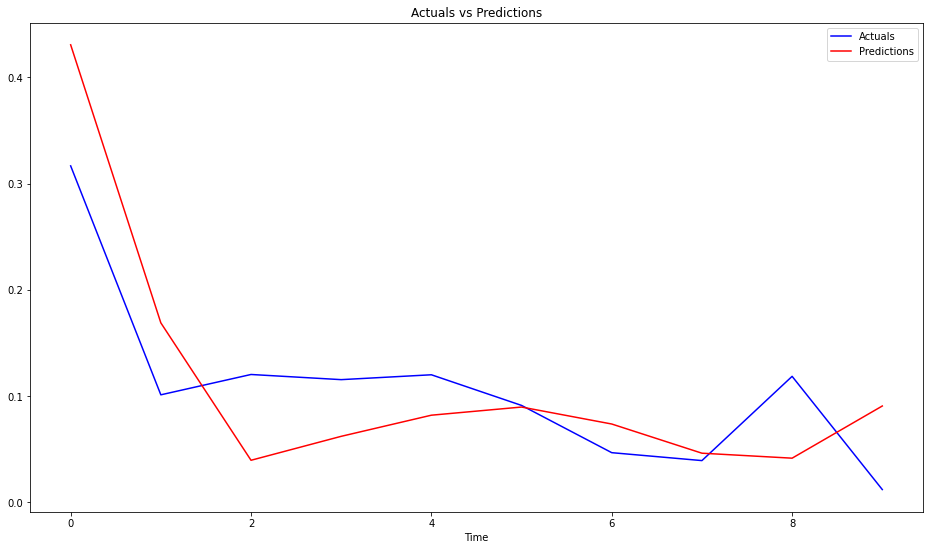

In [75]:
# Plot test data predictions
def plot_pred(y_test,y_pred,period=10):
    plt.figure(figsize=(16,9))
    plt.plot(y_test[-period:], "b", label="Actuals")
    plt.plot(y_pred[-period:], "r", label="Predictions")
    plt.title("Actuals vs Predictions")
    plt.xlabel("Time")
    plt.legend()
    plt.show()

plot_pred(y_test,y_pred)

To get a sense of the goodness of these predictions, we compute and plot the test data errors

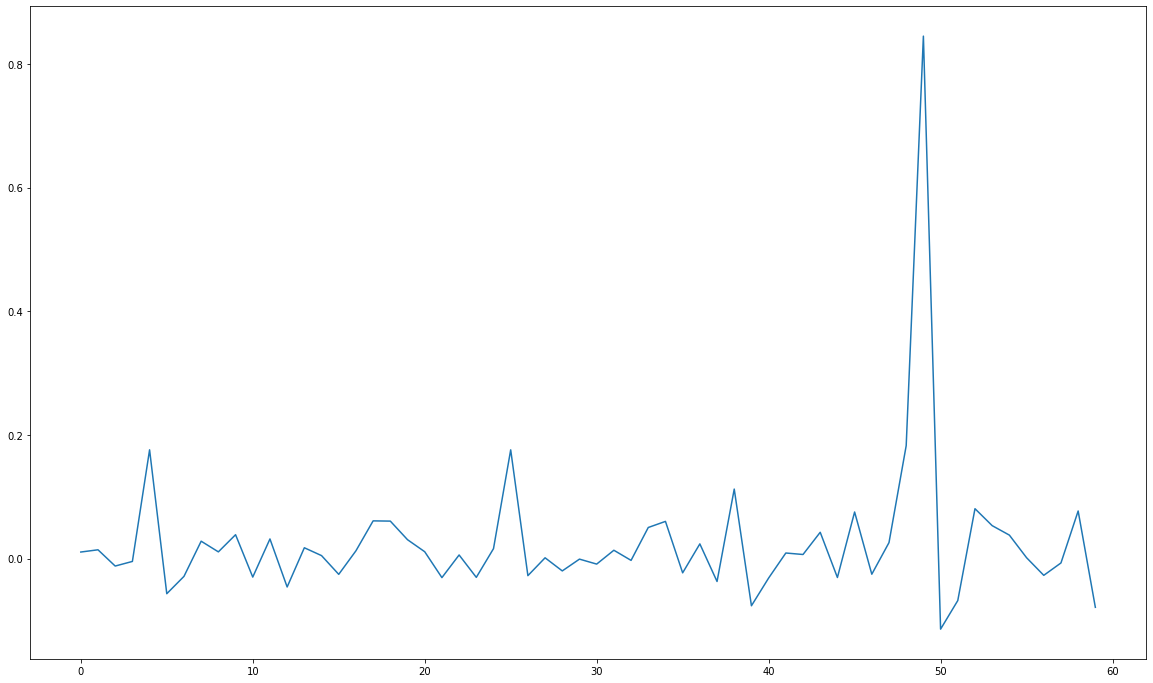

In [88]:
# Compute and plot the test data errors
errors = np.squeeze(y_test) - np.squeeze(y_pred)
plt.figure(figsize=(20,12))
plt.plot(errors)
# plt.figsize=(24,12))

You can conduct further analysis into the test data errors, for example corellograms to ascertain if there is any correlation, or checks of whether the errors are close to normally distributed.

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


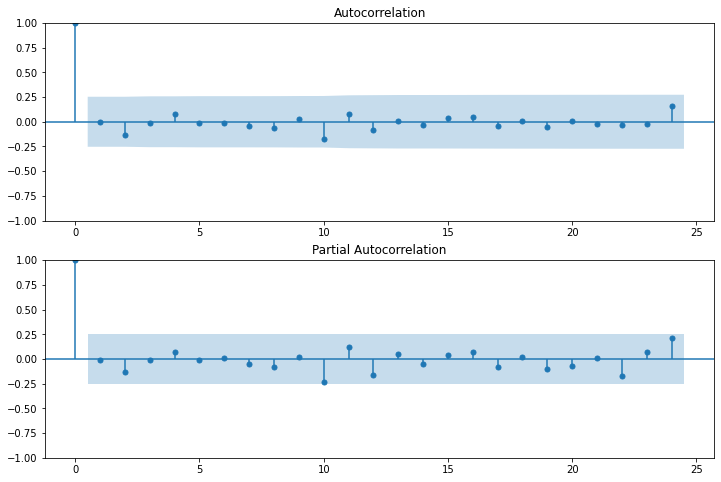

In [92]:
# check for evidence of autocorrelation
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(errors, lags=24, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(errors, lags=24, ax=ax2)

{'whiskers': [<matplotlib.lines.Line2D at 0x7fff14ea5f40>,
 'caps': [<matplotlib.lines.Line2D at 0x7fff152bc3d0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fff14ea5e20>],
 'medians': [<matplotlib.lines.Line2D at 0x7fff152bca30>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fff152bcbe0>],
 'means': []}

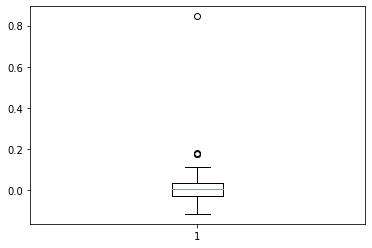

In [107]:
# # counts, bins = np.histogram(errors)
# plt.hist(bins[:-1], bins=10, weights=counts)
# plt.box(counts)
# # errors.plot.box(vert=False, title="Distribution of Culmen Depth (mm)")

fig, ax = plt.subplots()
ax.boxplot(errors)

### Multistep point prediction

In [77]:
def multistep_prediction(H, model, X_pred,residuals=[]):
    # Initialise lists for storing multi-step predictions
    y_pred_multi = []
    X_pred_multi = []

    for t in range(H):
        # get next prediction
        X_pred = np.array(X_pred.reshape(1,len(X_pred)))
        new_y= float(model.predict(X_pred))
        # print("new_y")
        # print(new_y)
    
        # update 
        y_pred_multi.append(float(new_y))
        X_pred_multi.append(list(X_pred[0])) 
        # print("y_pred_multi")
        # print(y_pred_multi)
        # print("X_pred_multi")
        # print(X_pred_multi)
    
        # prepare net input with bootstrapped training residuals
        X_pred = X_pred_multi[t][:-1]
        if len(residuals) == 0:
            X_pred.insert(0,new_y)
        else:
            X_pred.insert(0,(new_y+np.random.choice(residuals)))
        X_pred = np.array(X_pred)
        # print("new X")
        # print(X_pred)
        
    return y_pred_multi, X_pred_multi

1/1 [==============================] - 0s 37ms/step


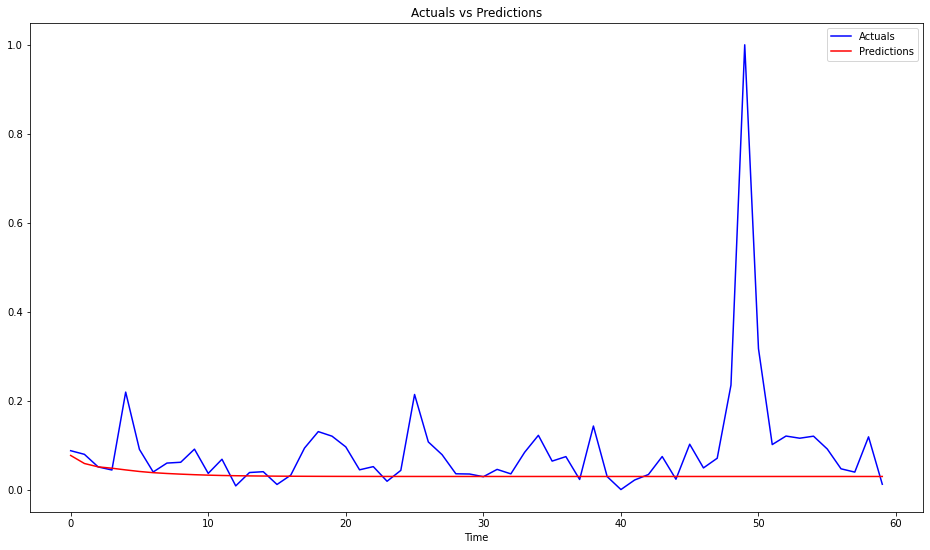

In [78]:
# Prediction horizon
H = 60 # extend prediction horizon to end of dataset

X_test_multi = X_test[-H:,:]
y_test_multi = y_test[-H:]
# y_pred_multi = model.predict(X_test_multi)    
# plot_pred(y_test_multi,y_pred_multi)

# Prepare first input to multistep prediction loop
X_pred = X_test_multi[0,:]

# Multistep prediction
y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred)
plot_pred(y_test_multi, y_pred_multi, period=H)

### Bootstrapping for interval predictions

In [79]:
residuals = np.squeeze(y_train) - np.squeeze(model.predict(X_train))

 79/160 [=============>................] - ETA: 0s

2022-11-01 11:19:38.443413: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 81424 exceeds 10% of free system memory.


160/160 [==============================] - 0s 1ms/step


In [80]:
# Bootstrap iterations
K = 50
# reduce prediction horizon for bootstrap to 1 month, if prediction horizon is 3 months the computation takes too long
H = 20

# Prepare first input to multistep bootsrtap loop
X_pred = X_test_multi[0,:]
y_pred_bootstrap = []

# Use multistep prediction to generate bootstrap data, 
# List of training residuals to sample from passed in as fourth argument 

for k in range(K):
    y_pred_multi, X_pred_multi = multistep_prediction(H,model,X_pred,residuals)
    # store y predictions
    y_pred_bootstrap.append(y_pred_multi)
    

1/1 [==============================] - 0s 38ms/step


### Visualising bootstrapped interval forcasts

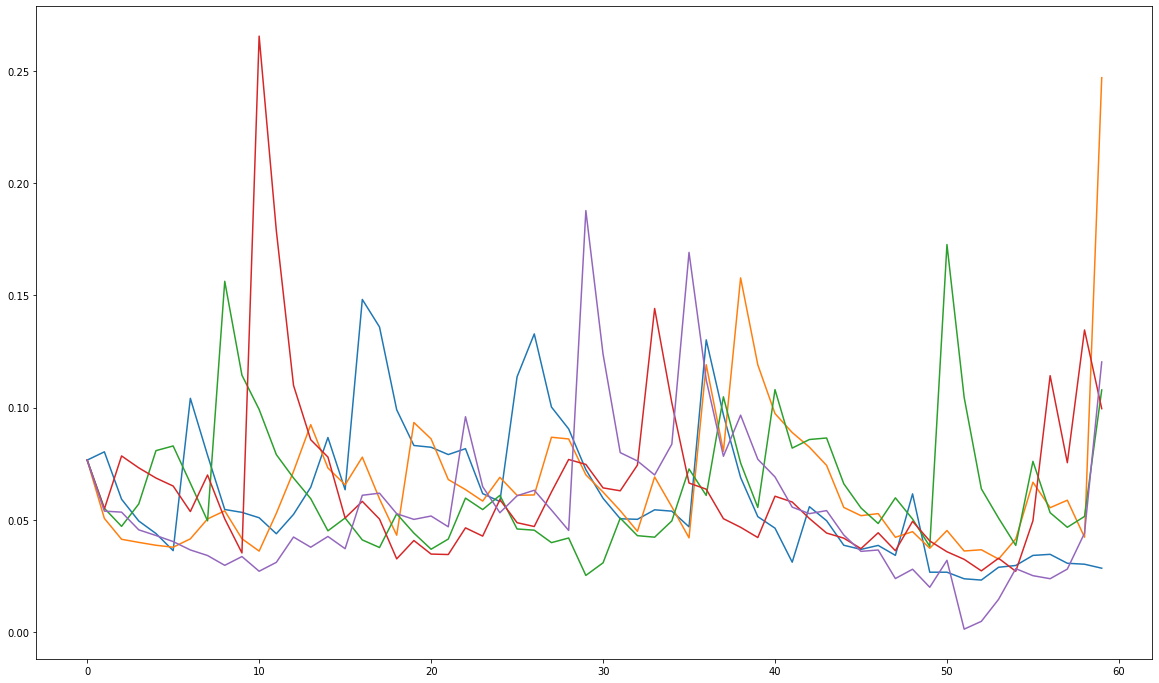

In [89]:
# Useful utility method for transposing lists of lists    
def transposed_2d_list(l):
    return [[row[i] for row in l] for i in range(len(l[0]))]    

plt.figure(figsize=(20,12))
plt.plot(transposed_2d_list(y_pred_bootstrap[-5:]))

In [82]:
bootstrap_predictions = pd.DataFrame(index = prev_data.index.values[-H:])

for pctl in range(0,101,10):
    bootstrap_predictions[str(pctl)] = np.percentile(y_pred_bootstrap,pctl,axis=0)

bootstrap_predictions.rename(columns={'50': "median"}, inplace=True)
bootstrap_predictions['actuals'] = y_test[-H:]

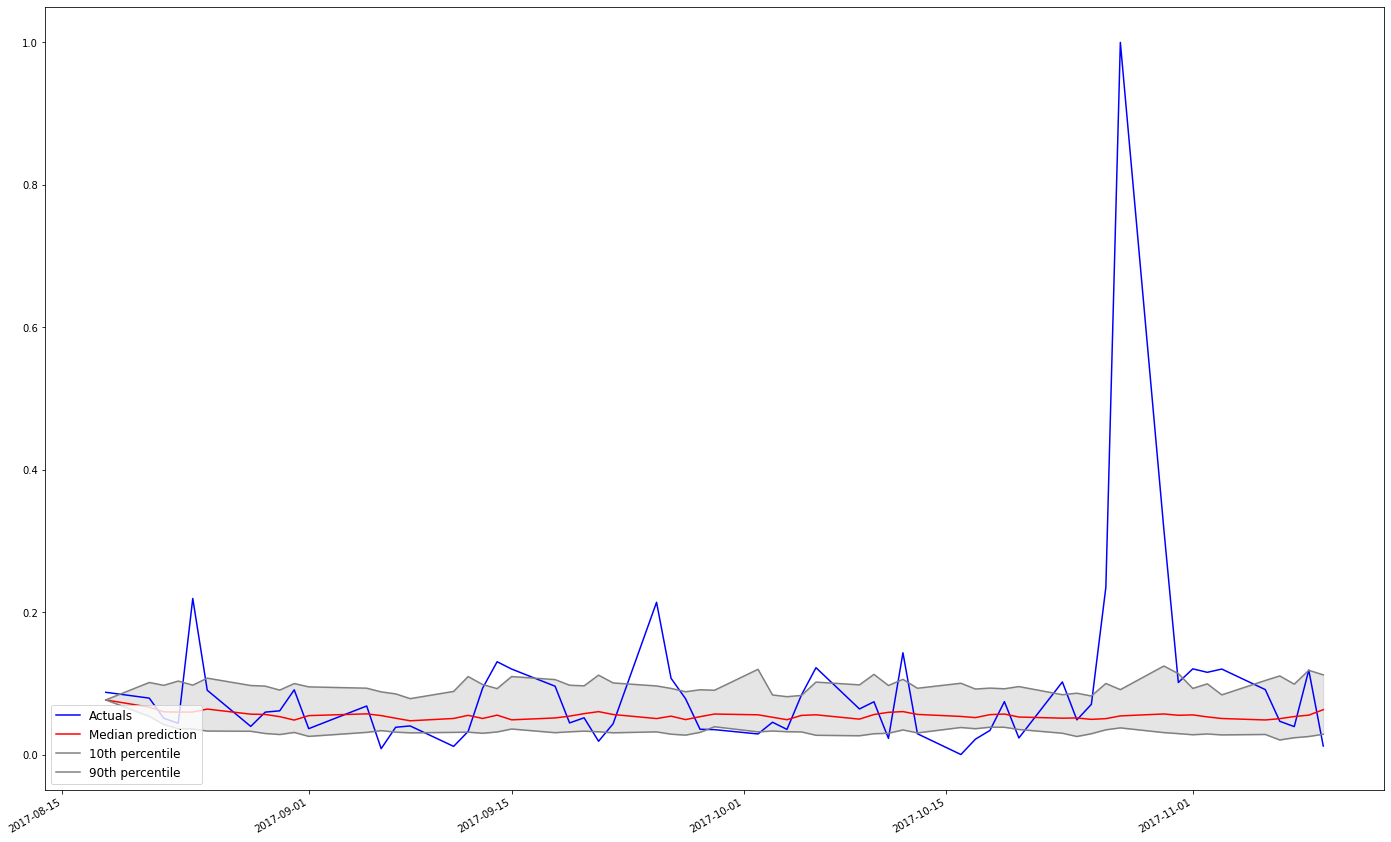

In [91]:
# plot interval with fill
fig, ax_bootstrap = plt.subplots(figsize=(24,16))
bootstrap_predictions['actuals'].plot(color = 'blue', label='Actuals', axes=ax_bootstrap)
bootstrap_predictions['median'].plot(color = 'red',label = 'Median prediction', axes=ax_bootstrap )
bootstrap_predictions['10'].plot(color = 'grey', label = '10th percentile', axes=ax_bootstrap )
bootstrap_predictions['90'].plot(color = 'grey', label = '90th percentile', axes=ax_bootstrap )
plt.legend(loc = 'lower left', fontsize = 12)

x = prev_data.index.values[-H:]
plt.fill_between(x, bootstrap_predictions['10'], bootstrap_predictions['90'], color='grey', alpha=0.2)

# Task 6 - Model Evaluation
Evaluate the forecast performance of your model-based and pure forecasters using the test data and compare the two forecasters. Use appropriate evaluation metrics and methods. Discuss the similarities and difference between their performance and suggest possible avenues for improvement.

Mean absolute error for point forcasting and quartile scores for distributional forcast accuracy

In [116]:
from sklearn.metrics import mean_absolute_error

### Mean absolute error

In [133]:
test_amazon

Datetime
2017-08-18     3276718
2017-08-21     3157620
2017-08-22     2745802
2017-08-23     2644883
2017-08-24     5192822
2017-08-25     3318454
2017-08-28     2580401
2017-08-29     2871789
2017-08-30     2898148
2017-08-31     3327043
2017-09-01     2533975
2017-09-05     2996690
2017-09-06     2125703
2017-09-07     2562567
2017-09-08     2589603
2017-09-11     2172012
2017-09-12     2476747
2017-09-13     3362218
2017-09-14     3900801
2017-09-15     3751327
2017-09-18     3400824
2017-09-19     2651065
2017-09-20     2755736
2017-09-21     2276738
2017-09-22     2632770
2017-09-25     5115458
2017-09-26     3562792
2017-09-27     3146172
2017-09-28     2521390
2017-09-29     2513654
2017-10-02     2425704
2017-10-03     2665119
2017-10-04     2518564
2017-10-05     3223573
2017-10-06     3779449
2017-10-09     2936290
2017-10-10     3083184
2017-10-11     2335171
2017-10-12     4083590
2017-10-13     2429486
2017-10-16     2005410
2017-10-17     2318835
2017-10-18     2497400
20

In [145]:
# Scale arima data to match neural net scaled data
arima_y_pred = arima_predictions['trend+seasonal'].to_numpy()
arima_y_test = test_amazon.to_numpy()

arima_y_pred_scaled = scaler.fit_transform([arima_y_pred])
arima_y_test_scaled = scaler.fit_transform([arima_y_test])

arima_mae = mean_absolute_error(arima_y_pred_scaled, arima_y_test_scaled)
nn_mae = mean_absolute_error(y_pred_multi, y_test_multi)

print(f"ARIMA MAE = {arima_mae}\n Neural Net MAE = {nn_mae}")

ARIMA MAE = 0.0
 Neural Net MAE = 0.0699037529907003


In [144]:
arima_y_test

array([ 3276718,  3157620,  2745802,  2644883,  5192822,  3318454,
        2580401,  2871789,  2898148,  3327043,  2533975,  2996690,
        2125703,  2562567,  2589603,  2172012,  2476747,  3362218,
        3900801,  3751327,  3400824,  2651065,  2755736,  2276738,
        2632770,  5115458,  3562792,  3146172,  2521390,  2513654,
        2425704,  2665119,  2518564,  3223573,  3779449,  2936290,
        3083184,  2335171,  4083590,  2429486,  2005410,  2318835,
        2497400,  3085640,  2343748,  3488072,  2713570,  3030196,
        5421431, 16552598,  6613064,  3476967,  3755511,  3684876,
        3751480,  3331738,  2684443,  2576010,  3729978,  2179181])